# HS subtypes and spontaneous saccades

Analyze Bettina's old data to extract spontaneous saccades and compare to HS subtype identity.

# Setup

In [1]:
import os
from pathdefs import *
#os.chdir("C:/Users/fischer/notebooks")
#os.chdir("C:/Users/Phil/documents/notebooks")
os.chdir(SOURCEPATH)
import importlib
#import DirectionTuning_Analyzer as dt
#import Looming_with_background_Analyzer as lwb
import baseClasses as bc
#importlib.reload(bc)

import numpy as np
import matplotlib.pyplot as plt
#from scipy import fftpack
from scipy import signal
from scipy import stats
from scipy import ndimage
import pdb
import pywt
import plotly.express as px

In [2]:
%matplotlib notebook

In [3]:
class DummyAnalyzer(bc.BaseAnalyzer):
    #LoomingWB_version = '1.0.4'#to keep track of class versions, makes easier to check for changes. Starts with 1.0.0 on 18.1.2020
    """version 1.0.0 changes timeax such that time coordinate 0  is at the end of looming"""
    stimulusmap = {0.5:'loom left rot. clw', 1.0:'loom left rot. cck', 1.5:'loom left no rot.',
                  2.0:'loom right rot. clw', 2.5:'loom right rot. cck', 3.0:'loom right no rot.',
                  3.5:'no loom rot. clw', 4.0:'no loom rot. cck'}
    stimulusPhases_inframes = [0,47,60,74] #frame numbers where stuff changes
    stimulus_period_inframes = 60
    preStim = 0.0 #s
    afterStim = 0.0 #s
    kineflyPeriod=0.02
    
    #def __init__(self, fpath, *args, **kwargs):
    def __init__(self, loader, *args, **kwargs):
        #loader = bc.DataLoader(fpath)
        fpath = loader.file
        data, samplingRate = loader.get_data()
        samplingRate = round(samplingRate/100.,0)*100.
        """if data.shape[0]==5:
            data[1,:] = signal.medfilt(data[1,:], 51)
            data[2,:] = signal.medfilt(data[2,:], 51)
        elif data.shape[0]==4:
            data[1,:] = signal.medfilt(data[1,:], 9)
            data[2,:] = signal.medfilt(data[2,:], 9)
        """
        stimBound = loader.get_stimulusBoundaries()
        stimBound[0::2] = stimBound[0::2]-self.preStim*samplingRate
        stimBound[1::2] = stimBound[1::2]+self.afterStim*samplingRate
        #newBounds = np.array(zip(stimBound[1::2], stimBound[0::2]))
        #newBounds = np.concatenate(([0],stimBound,[data.shape[1],]))
        newBounds = stimBound
        if data[4, 0]<0.05:
            newBounds = np.concatenate(([0], newBounds[:]))
        if data[4, -1]<0.05:
            newBounds = np.concatenate((newBounds[:], [data.shape[1]]))
#         newBounds = np.concatenate(([0], stimBound[:], [data.shape[1]]))
        #lastPiece = newBounds[-1]-newBounds[-2]
        #lastPiece=1000
#         lastPiece=1
#         pdb.set_trace()
#         print([ (newBounds[i]-newBounds[i-1],newBounds[i+1]-newBounds[i]-2*lastPiece,lastPiece) for i in range(2,newBounds.size-1,2)])
#         data[4] = np.concatenate(( np.zeros(newBounds[1]-2*lastPiece),np.ones(lastPiece), np.zeros(lastPiece), 
#                                   np.concatenate([np.concatenate(( np.zeros(newBounds[i]-newBounds[i-1]),
#                                                   np.zeros(newBounds[i+1]-newBounds[i]-2*lastPiece),
#                                                   np.ones(lastPiece),np.zeros(lastPiece)))
#                                           for i in range(2,newBounds.size-1,2)])
#                           #, np.ones(lastPiece), np.zeros(newBounds[-1]-newBounds[-2]) #somehow too much
#                           ))
        metas = loader.get_metadata()
        super(DummyAnalyzer, self).__init__(newBounds, data, Fs=samplingRate, fname=fpath.split('/')[-1], metadata=metas, **kwargs)
        self.timeax = self.timeax-self.preStim-self.stimulusPhases_inframes[1]*self.meanFramePeriod #center 0 on end of loom

In [4]:
# refer to https://gist.github.com/dmeliza/3251476
# dmeliza     dmeliza/scalebars.py 
from matplotlib.offsetbox import AnchoredOffsetbox
class AnchoredScaleBar(AnchoredOffsetbox):
    def __init__(self, transform, sizex=0, sizey=0, labelx=None, labely=None, loc=4,
                 pad=0.1, borderpad=0.1, sep=2, prop=None, barcolor="black", barwidth=None, 
                 **kwargs):
        """
        Draw a horizontal and/or vertical  bar with the size in data coordinate
        of the give axes. A label will be drawn underneath (center-aligned).
        - transform : the coordinate frame (typically axes.transData)
        - sizex,sizey : width of x,y bar, in data units. 0 to omit
        - labelx,labely : labels for x,y bars; None to omit
        - loc : position in containing axes
        - pad, borderpad : padding, in fraction of the legend font size (or prop)
        - sep : separation between labels and bars in points.
        - **kwargs : additional arguments passed to base class constructor
        """
        from matplotlib.patches import Rectangle
        from matplotlib.offsetbox import AuxTransformBox, VPacker, HPacker, TextArea, DrawingArea
        bars = AuxTransformBox(transform)
        if sizex:
            bars.add_artist(Rectangle((0,0), sizex, 0, ec=barcolor, lw=barwidth, fc="none"))
        if sizey:
            bars.add_artist(Rectangle((0,0), 0, sizey, ec=barcolor, lw=barwidth, fc="none"))

        if sizex and labelx:
            self.xlabel = TextArea(labelx, minimumdescent=False, textprops={'fontname':'arial', 'fontsize':8.})
            bars = VPacker(children=[bars, self.xlabel], align="center", pad=0, sep=sep)
        if sizey and labely:
            self.ylabel = TextArea(labely, textprops={'fontname':'arial', 'fontsize':8.})
            bars = HPacker(children=[self.ylabel, bars], align="center", pad=0, sep=sep)

        AnchoredOffsetbox.__init__(self, loc, pad=pad, borderpad=borderpad,
                                   child=bars, prop=prop, frameon=False, **kwargs)

        
def add_scalebar(ax, matchx=True, matchy=True, hidex=True, hidey=True, **kwargs):
    """ Add scalebars to axes
    Adds a set of scale bars to *ax*, matching the size to the ticks of the plot
    and optionally hiding the x and y axes
    - ax : the axis to attach ticks to
    - matchx,matchy : if True, set size of scale bars to spacing between ticks
                    if False, size should be set using sizex and sizey params
    - hidex,hidey : if True, hide x-axis and y-axis of parent
    - **kwargs : additional arguments passed to AnchoredScaleBars
    Returns created scalebar object
    """
    def f(axis):
        l = axis.get_majorticklocs()
        return len(l)>1 and (l[1] - l[0])
    
    if matchx:
        kwargs['sizex'] = f(ax.xaxis)
        kwargs['labelx'] = str(kwargs['sizex'])
    if matchy:
        kwargs['sizey'] = f(ax.yaxis)
        kwargs['labely'] = str(kwargs['sizey'])
        
    sb = AnchoredScaleBar(ax.transData, **kwargs)
    ax.add_artist(sb)

    if hidex : ax.xaxis.set_visible(False)
    if hidey : ax.yaxis.set_visible(False)
    if hidex and hidey: ax.set_frame_on(False)

    return sb

In [5]:
import warnings

def subdivideSegment(segment, samplingRate, ax=None, w1_thresh=0.1, w2_thresh=0.1):
    w1 = segment.data[1]
    w2 = segment.data[2]
    low1 = w1>w1_thresh
    low2 = w2>w2_thresh
    #medfilter is too time-consuming here, filter resulting limits instead
    # low1 = signal.medfilt(low1,int(3*0.02*samplingRate)+1)
    # low2 = signal.medfilt(low2,int(3*0.02*samplingRate)+1)
    # trans = np.nonzero(np.diff(np.logical_and(low1,low2)))[0]
    # signchange = np.diff(np.diff(np.logical_and(low1,low2)))
    signchange = np.diff(np.logical_and(low1,low2).astype(int))
    trans = np.nonzero(signchange)[0]

    signchange = signchange[trans]
    if len(signchange)==0:
        #pdb.set_trace()
        warnings.warn('Returning empty start/stop list, no rest, only "misdetections"')
        #raise Exception('Invalid result: junk segment always contains some flight')
        return [],[]
    # distinguish where flight starts and where ends
    starts = trans[signchange>0]
    stops = trans[signchange<0]
    # make start/stop list complete
    if low1[0]:#is flying at beginning of segment
        assert(low1[0]==low2[0])
        starts = np.concatenate(([0], starts))
    if low1[-1]:#flying till the end
        assert(low1[-1]==low2[-1])
        stops = np.append(stops, [w1.size])
    # these are equivalent conditions, but have problem where start or stop is empty at first
#     if stops[0]<starts[0]: # case where piece of data starts in flight
#         assert(low1[0]==low2[0]==True)
#         starts = np.concatenate(([0], starts))
#     if stops[-1]<starts[-1]: # case where piece of data ends in flight
#         assert(low1[-1]==low2[-1]==True)
#         stops = np.append(stops, [w1.size])
    assert(starts.size==stops.size)

    # get rid of cutoffs due to measurement noise
    #first make small misdetections disappear from start/stop list
    rm = []
    for i in range(len(stops)-1):
        if starts[i+1]-stops[i]<1.5*0.02*samplingRate:
            rm.append(i)
    if len(rm)>0:
        stops = np.delete(stops, rm)
        starts = np.delete(starts, np.array(rm)+1)
    # [ax.axvline(x, color='r', linestyle='-') for x in starts]
    # [ax.axvline(x, color='r', linestyle=':') for x in stops]

    # #give some extra slack
    starts += int(0.15*samplingRate) #150ms
    stops -= int(0.15*samplingRate)

    # #check if flight bouts are too short, only flight, don't care about rest periods here anyway
    rm = []
    for i in range(len(starts)):
        if stops[i]-starts[i] < 2.1*0.02*samplingRate:
            rm.append(i)
    if len(rm)>0:
        starts = np.delete(starts, rm)
        stops = np.delete(stops, rm)
    assert(starts.size==stops.size)
    # [ax.axvline(x, color='g', linestyle='-') for x in starts]
    # [ax.axvline(x, color='g', linestyle=':') for x in stops]
    return starts,stops

# Load data

In [6]:
root = os.path.join(DATAPATH,'vonBettina','oldHSdata_adaptedFormat')

In [13]:
def fileGen(root):
    dircontent = os.listdir(root) 
    for f in dircontent:
        print(f)
        yield f

fileIterator = fileGen(root)

## sanity check for datafiles

In [18]:
os.listdir(root)
fn = os.listdir(root)[22]
fn

'fly1_wtcs_age_na_cell2_HSS_2012_01_04_00_00_00.mat'

I removed the file from 2012 02 14 cell2 because it has a very different format, like a different order of channels, experiment procedure or something. I don't know, have to ask

## get file of fly

fly1_wtcs_age_na_cell2_HSS_2012_01_04_00_00_00.mat


<IPython.core.display.Javascript object>


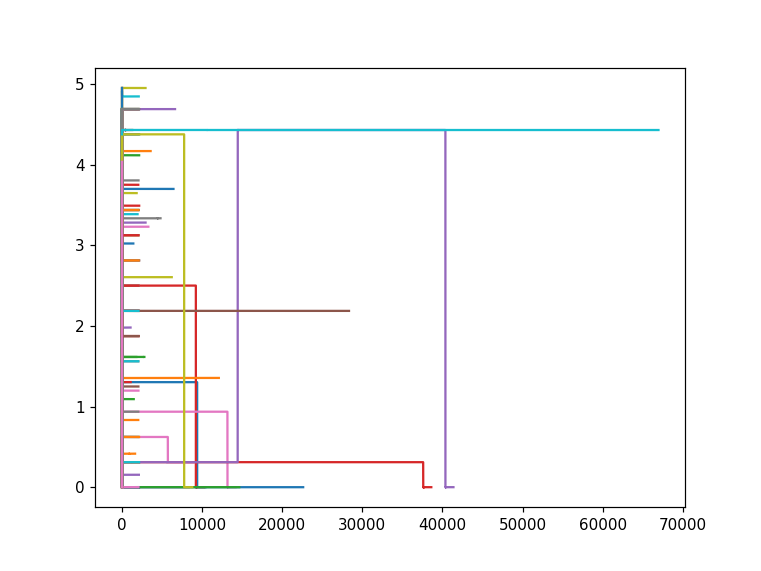

In [19]:
# this cell should be repeated after initiating above
#fn = next(fileIterator)
print(fn)
# if not '2013' in fn:
#     assert False
loader = bc.DataLoader(os.path.join(root,fn))
anlyz = DummyAnalyzer(loader, meanFramePeriod=0.05)
for k in list(anlyz.metadata[0].keys()):
    if k[:2]=='HS':
        anlyz.metadata[0]['HS_type']=k
f,ax=plt.subplots(1,1)
[ax.plot(s.data[anlyz.channelmap['arenaOut'],::10]) for s in anlyz.segments]
print()

## quality control

<IPython.core.display.Javascript object>


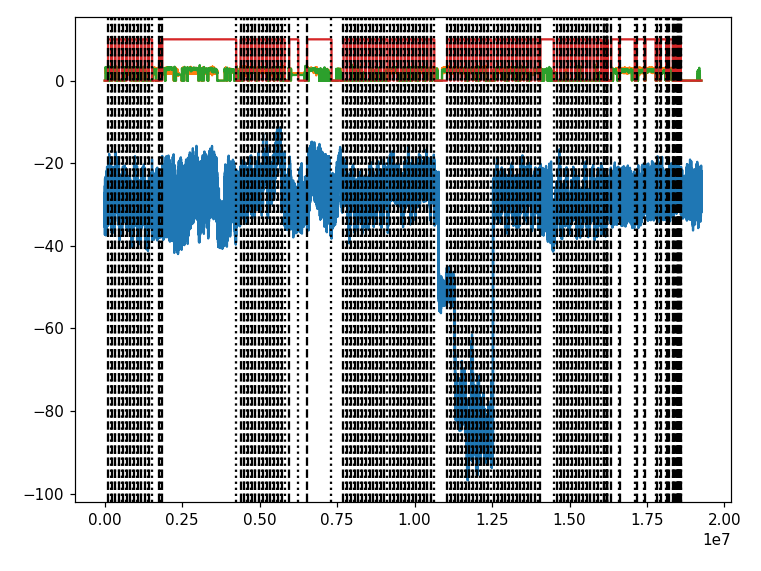

In [20]:
# check for problems with Vm during non-stimulus periods
f,ax=plt.subplots(1,1)
reductionFactor = 10
timeax = range(0,loader.data.shape[1], reductionFactor)
ax.plot(timeax, loader.data[0,::reductionFactor])
ax.plot(timeax, loader.data[1,::reductionFactor])
ax.plot(timeax, loader.data[2,::reductionFactor])
ax.plot(timeax, loader.data[4,::reductionFactor]*10.)# make more prominent
sb =loader.get_stimulusBoundaries()
for i in range(0,len(sb),2):
    ax.axvline(sb[i], linestyle='--', color='k')
    ax.axvline(sb[i+1], linestyle=':', color='k')
plt.tight_layout()

In [21]:
rm=[]
for i,s in enumerate(anlyz.segments):
    if s.boundaries[0]>1.075e7 and s.boundaries[0]<1.255e7:
    #if s.boundaries[0]>4e6:
        print(s.boundaries)
        rm.append(i)
print(rm)

if input("is this ok? [y/n]  ").lower()=='y':
    anlyz.remove_duds_byList(rm)

[12469919 12558860]
[12349624 12370094]
[12229102 12249799]
[12108825 12129519]
[11988971 12009242]
[11867717 11888965]
[11748643 11768977]
[11628502 11648818]
[11507985 11528678]
[11387843 11408402]
[11266994 11288259]
[11147965 11168254]
[16, 17, 18, 19, 20, 21, 22, 23, 39, 53, 54, 55]
is this ok? [y/n]  y


<IPython.core.display.Javascript object>


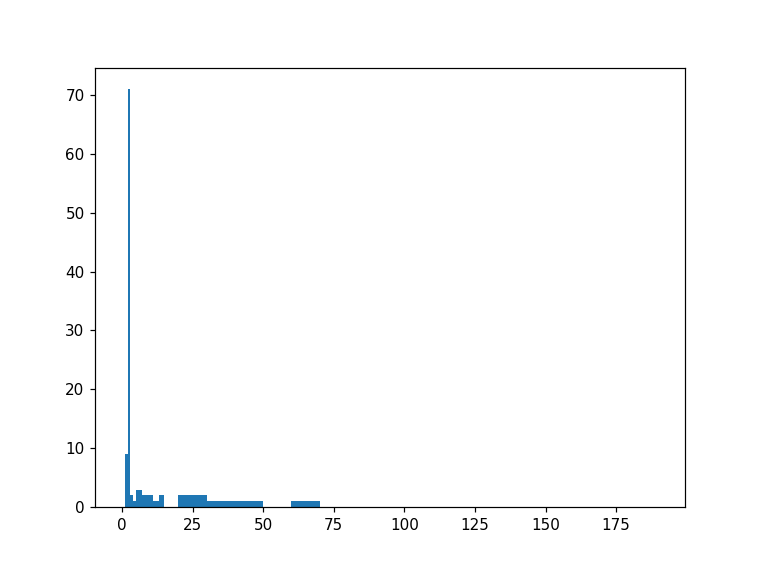

(array([ 0.,  9., 71.,  2.,  1.,  3.,  2.,  2.,  1.,  2.,  0.,  0.,  0.,
         2.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.]),
 array([  0,   1,   2,   3,   4,   5,   7,   9,  11,  13,  15,  17,  19,
         20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130, 140,
        150, 160, 170, 180, 190]),
 <BarContainer object of 30 artists>)

In [22]:
# how long are trials
f,ax=plt.subplots(1,1)
ax.hist([(s.boundaries[1]-s.boundaries[0])/anlyz.samplingRate for s in anlyz.segments ], 
        bins=np.concatenate((np.arange(0,5,1), np.arange(5,20,2),np.arange(20,200,10))))


## how much flying?

<IPython.core.display.Javascript object>


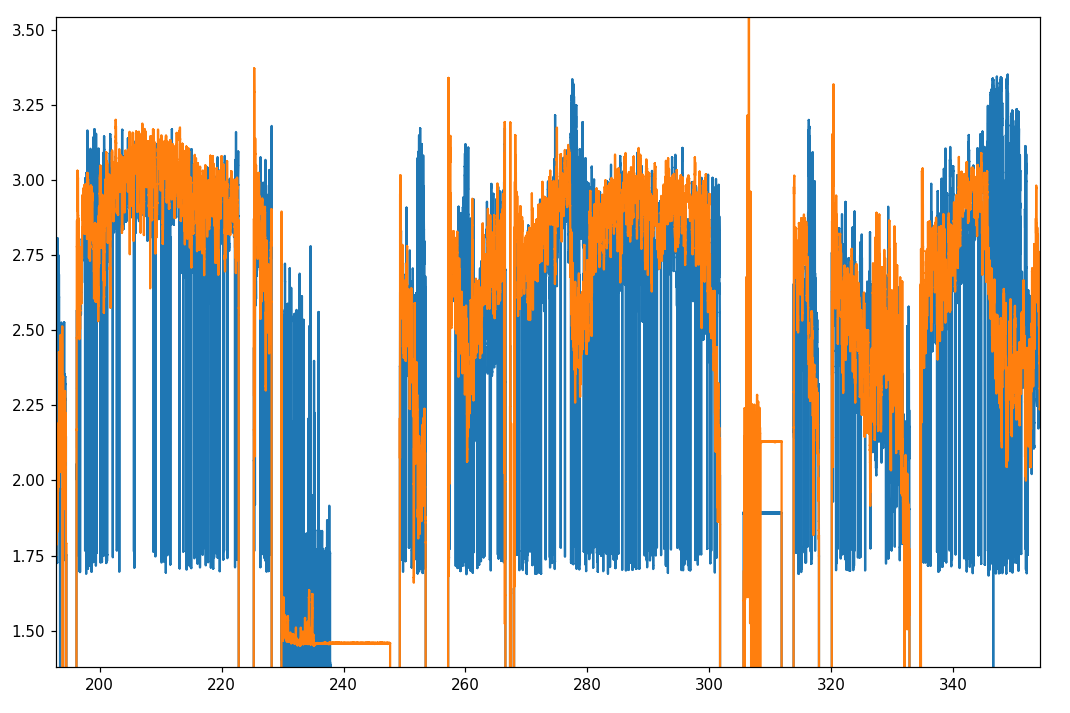

In [23]:
#anlyz.plot_by_stimSignal('wingR')
f,ax=plt.subplots(1,1, figsize=(9,6))
ax.plot(np.arange(0,loader.data.shape[1],5)/anlyz.samplingRate,loader.data[1,::5])
ax.plot(np.arange(0,loader.data.shape[1],5)/anlyz.samplingRate, loader.data[2,::5])
ax.plot(np.arange(0,loader.data.shape[1],5)/anlyz.samplingRate, loader.data[-1,::5])
# ax.plot(np.arange(0,loader.data.shape[1],5)/anlyz.samplingRate, loader.data[3,::5])
plt.tight_layout()

<IPython.core.display.Javascript object>


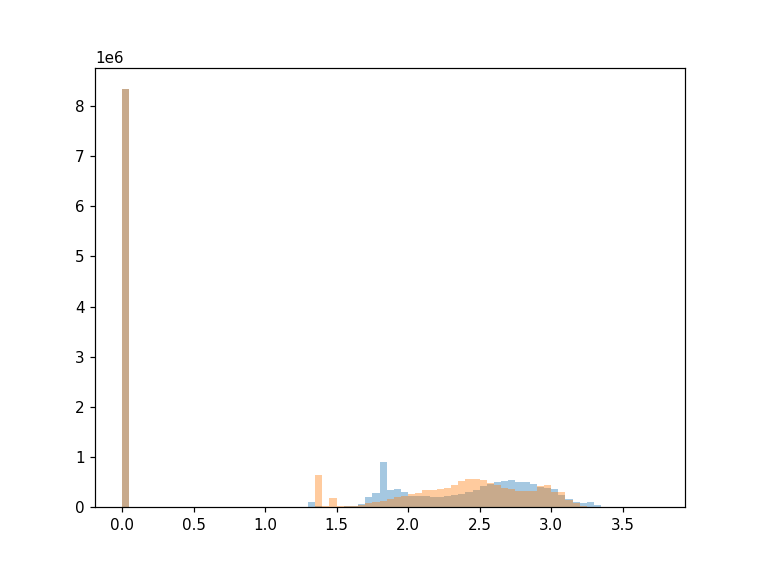

In [24]:
f,ax=plt.subplots(1,1)
#[ax.hist(s.data[1],bins=np.arange(0,3.8,0.1), alpha=0.3) for s in anlyz.segments[:5] ]
ax.hist(loader.data[1],bins=np.arange(0,3.8,0.05), alpha=0.4)
ax.hist(loader.data[2],bins=np.arange(0,3.8,0.05), alpha=0.4)
print()

# Preselect flying trials

That means, the intertrial intervals where the fly was flying. Do it like usual in the other notebook

<IPython.core.display.Javascript object>


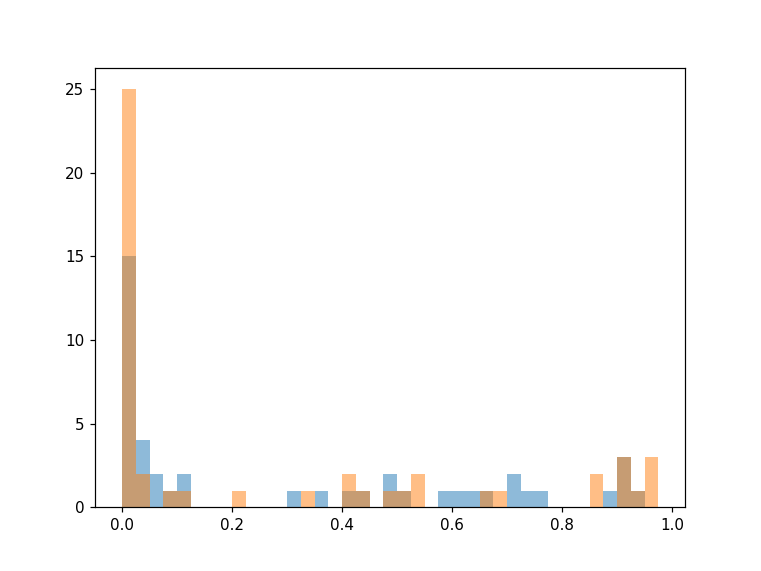

<IPython.core.display.Javascript object>


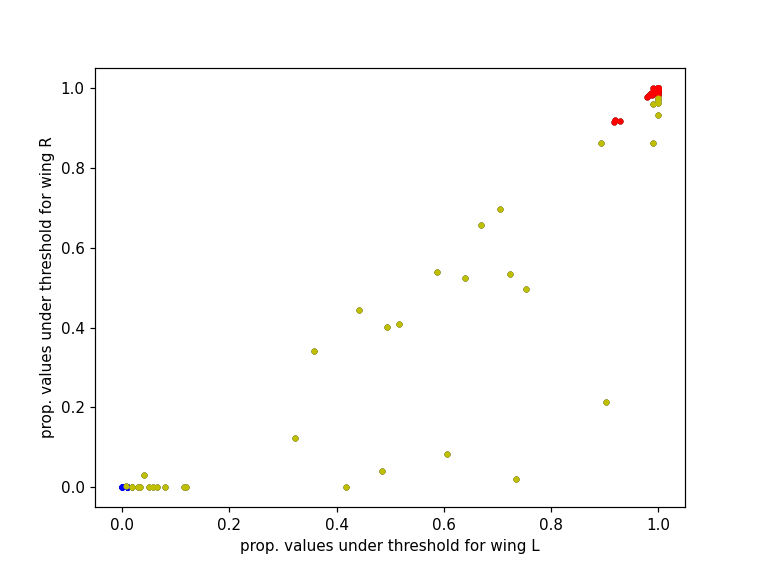

Text(0, 0.5, 'prop. values under threshold for wing R')

In [25]:
## VERY SIMPLE METHOD, COUNTING THRESHOLDED VALUES AND THRESHOLD THAT
theta_1 = 1.9
theta_2 = 1.6
f,ax=plt.subplots(1,1)
#t2=np.array([np.sum(np.logical_or(anlyz.segments[i].data[2]>1.6, np.logical_and(anlyz.segments[i].data[2]>-theta, anlyz.segments[i].data[2]<theta))) for i in range(anlyz.segments.size)])

# t1= np.array([np.sum(np.logical_or(anlyz.segments[i].data[1] < 1.6 ,
#                                    anlyz.segments[i].data[1]<theta) ) for i in range(anlyz.segments.size)])
# t1= np.array([np.sum(np.logical_or(anlyz.segments[i].data[1] < 1.6 ,
#                                    anlyz.segments[i].data[1]<theta) ) for i in range(anlyz.segments.size)])
t1= np.array([np.sum(anlyz.segments[i].data[1]<theta_1) for i in range(anlyz.segments.size)])
# t2= np.array([np.sum(np.logical_or(anlyz.segments[i].data[2] > 3.35 ,
#                                    anlyz.segments[i].data[2]<theta_2) ) for i in range(anlyz.segments.size)])
t2= np.array([np.sum(anlyz.segments[i].data[2] < theta_2) for i in range(anlyz.segments.size)])

# ax.hist(t1,alpha=0.5, bins=np.arange(-250,t1.max()+250, 500))
# ax.hist(t2,alpha=0.5, bins=np.arange(-250,t2.max()+250, 500))
segmentLengths = np.array([s.data.shape[1] for s in anlyz.segments])
ax.hist(t1/segmentLengths,alpha=0.5, bins=np.arange(0,1,0.025))
ax.hist(t2/segmentLengths,alpha=0.5, bins=np.arange(0,1,0.025))

f,ax=plt.subplots(1,1)
# jitterForPlotting = np.random.rand(len(t1))/2
# ax.plot(t1/segmentLengths+jitterForPlotting,  t2/segmentLengths,'k.')
ax.plot(t1/segmentLengths,  t2/segmentLengths,'k.')
ax.set_xlabel('prop. values under threshold for wing L')
ax.set_ylabel('prop. values under threshold for wing R')

In [26]:
# COLORIZE data points (trials) that are (almost) all below threshold (nf=non-flying)
segmentLengths = np.array([s.data.shape[1] for s in anlyz.segments])
discrepancyTol = [max(sl*0.02, 0.05*anlyz.samplingRate) for sl in segmentLengths]
nf = np.where(np.logical_and(np.abs(t1-t2)<discrepancyTol, t1>(segmentLengths*0.9) ))[0]
#ax.plot(t1[nf]+jitterForPlotting[nf], t2[nf],'r.')
ax.plot(t1[nf]/segmentLengths[nf], t2[nf]/segmentLengths[nf],'r.')
nf

array([ 1,  2,  3,  6,  7,  9, 10, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 57,
       60, 61, 64, 65, 67, 69, 70, 83, 85, 86, 87, 88, 89, 90, 92, 94, 95],
      dtype=int64)

In [27]:
# COLORIZE data points (trials) that are all above threshold (fl=flying)
fl = np.where(np.logical_and(np.abs(t1-t2)<0.03*anlyz.samplingRate, t1<0.03*anlyz.samplingRate))[0]
#fl = np.where(np.logical_and(np.abs(t1-t2)<0.11*anlyz.samplingRate, t1<0.05*anlyz.samplingRate))[0]
# ax.plot(t1[fl]+jitterForPlotting[fl], t2[fl],'b.')
ax.plot(t1[fl]/segmentLengths[fl], t2[fl]/segmentLengths[fl],'b.')
fl

array([ 5,  8, 13, 15, 44, 46, 48, 51, 53, 74, 76, 79], dtype=int64)

In [28]:
# define junk trials (=jk) as remaining ones, and colorize in plot
jk = np.ones(anlyz.segments.size, dtype=bool)
jk[nf]=False
jk[fl]=False
jk = np.nonzero(jk)[0]
# p=plt.plot(t1[jk]+jitterForPlotting[jk], t2[jk],'y.')
p=plt.plot(t1[jk]/segmentLengths[jk], t2[jk]/segmentLengths[jk],'y.')
jk

array([ 0,  4, 11, 12, 14, 17, 39, 45, 47, 49, 50, 52, 54, 55, 56, 58, 59,
       62, 63, 66, 68, 71, 72, 73, 75, 77, 78, 80, 81, 82, 84, 91, 93, 96,
       97], dtype=int64)

In [29]:
print(fl.size)
print(nf.size)
print(jk.size)

12
51
35


### intervene in "junk" trials to rescue
#### figure out which parts to keep and store as new BaseAnalyzer instance

In [30]:
res = []
for trialNo in jk:
    #print(f'{trialNo=}')#new python version
    print(f'trialNo={trialNo}')
    orig_boundaries = anlyz.segments[trialNo].boundaries
    starts,stops = subdivideSegment(anlyz.segments[trialNo], anlyz.samplingRate)
    if len(starts)==0:
        continue
    newAnlyz = bc.BaseAnalyzer(np.sort(np.concatenate((starts,stops))), anlyz.segments[trialNo].data[:-1] ,
                Fs=anlyz.samplingRate, metadata=anlyz.metadata[0], meanFramePeriod=anlyz.meanFramePeriod)
    # get rid of segments that are too short
    print(f'#segments before cleaning: {len(newAnlyz)}')
    rm=[]
    for i in range(len(newAnlyz)):
        if len(newAnlyz.segments[i]) < 1.5*anlyz.samplingRate:
            rm.append(i)
    newAnlyz.remove_duds_byList(rm)
    print(f'#segments after cleaning: {len(newAnlyz)}')
    # correct segment boundaries for original offset, in case we need them at some point
    for seg in newAnlyz.segments:
        seg.boundaries += orig_boundaries[0]
    if not len(newAnlyz)==0:
        res.append(newAnlyz)
newAnlyz = sum(res)
print(f'#segments rescued total: {len(newAnlyz)}')

trialNo=0
#segments before cleaning: 2
#segments after cleaning: 1
trialNo=4
#segments before cleaning: 1
#segments after cleaning: 1
trialNo=11
trialNo=12
#segments before cleaning: 1
#segments after cleaning: 1
trialNo=14
trialNo=17
trialNo=39
trialNo=45
#segments before cleaning: 1
#segments after cleaning: 0
trialNo=47
trialNo=49
trialNo=50
trialNo=52
#segments before cleaning: 2
#segments after cleaning: 0
trialNo=54
#segments before cleaning: 2
#segments after cleaning: 1
trialNo=55
trialNo=56
trialNo=58
#segments before cleaning: 1
#segments after cleaning: 1
trialNo=59
trialNo=62
trialNo=63
trialNo=66
trialNo=68
#segments before cleaning: 2


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Returning empty start/stop list, no rest, only "misdetections"
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Returning empty start/stop list, no rest, only "misdetections"
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Returning empty start/stop list, no rest, only "misdetections"
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Returning empty start/stop list, no rest, only "misdetections"
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Returning empty start/stop list, no rest, only "misdetections"


#segments after cleaning: 1
trialNo=71
#segments before cleaning: 2
#segments after cleaning: 2
trialNo=72
#segments before cleaning: 3
#segments after cleaning: 3
trialNo=73
#segments before cleaning: 1
#segments after cleaning: 1
trialNo=75
#segments before cleaning: 1
#segments after cleaning: 0
trialNo=77
#segments before cleaning: 1
#segments after cleaning: 1
trialNo=78
#segments before cleaning: 1
#segments after cleaning: 0
trialNo=80
#segments before cleaning: 1
#segments after cleaning: 0
trialNo=81
trialNo=82
#segments before cleaning: 1
#segments after cleaning: 0
trialNo=84
trialNo=91
trialNo=93
trialNo=96
#segments before cleaning: 1
#segments after cleaning: 1
trialNo=97
#segments before cleaning: 2
#segments after cleaning: 0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Returning empty start/stop list, no rest, only "misdetections"


#segments rescued total: 14


#### feed new results into original analyzer
need to delete the junky trials first, then add our new analyzer to old one

In [31]:
print(len(anlyz), len(jk))
anlyz.remove_duds_byList(jk)
print(len(anlyz))

98 35
63


In [32]:
anlyz = anlyz + newAnlyz
print(len(anlyz))

77


#### redo the calculation done above before converging to main branch
We need to establish that all our newly spawned segments adhere to the same standards and are not "junky" by themselves

In [33]:
## VERY SIMPLE METHOD, COUNTING THRESHOLDED VALUES AND THRESHOLD THAT
print(f'parameters for deciding if wing is beating and detected properly\n theta wing 1: {theta_1}\ntheta wing 2: {theta_2}')
# f,ax=plt.subplots(1,1)
t1= np.array([np.sum(anlyz.segments[i].data[1]<theta_1) for i in range(anlyz.segments.size)])
t2= np.array([np.sum(anlyz.segments[i].data[2] < theta_2) for i in range(anlyz.segments.size)])

segmentLengths = np.array([s.data.shape[1] for s in anlyz.segments])
# ax.hist(t1/segmentLengths,alpha=0.5, bins=np.arange(0,1,0.025))
# ax.hist(t2/segmentLengths,alpha=0.5, bins=np.arange(0,1,0.025))
# f,ax=plt.subplots(1,1)
# ax.plot(t1/segmentLengths,  t2/segmentLengths,'k.')
# ax.set_xlabel('prop. values under threshold for wing L')
# ax.set_ylabel('prop. values under threshold for wing R')

parameters for deciding if wing is beating and detected properly
 theta wing 1: 1.9
theta wing 2: 1.6


In [34]:
# COLORIZE data points (trials) that are (almost) all below threshold (nf=non-flying)
segmentLengths = np.array([s.data.shape[1] for s in anlyz.segments])
discrepancyTol = [max(sl*0.02, 0.05*anlyz.samplingRate) for sl in segmentLengths]
nf = np.where(np.logical_and(np.abs(t1-t2)<discrepancyTol, t1>(segmentLengths*0.9) ))[0]
# ax.plot(t1[nf]/segmentLengths[nf], t2[nf]/segmentLengths[nf],'r.')
print(f'nf: {nf}')

# COLORIZE data points (trials) that are all above threshold (fl=flying)
fl = np.where(np.logical_and(np.abs(t1-t2)<0.03*anlyz.samplingRate, t1<0.03*anlyz.samplingRate))[0]
#fl = np.where(np.logical_and(np.abs(t1-t2)<0.11*anlyz.samplingRate, t1<0.05*anlyz.samplingRate))[0]
# ax.plot(t1[fl]/segmentLengths[fl], t2[fl]/segmentLengths[fl],'b.')
print(f'fl: {fl}')

# define junk trials (=jk) as remaining ones, and colorize in plot
jk = np.ones(anlyz.segments.size, dtype=bool)
jk[nf]=False
jk[fl]=False
jk = np.nonzero(jk)[0]
# p=ax.plot(t1[jk]/segmentLengths[jk], t2[jk]/segmentLengths[jk],'y.')
print(f'jk: {jk}')

print(f'#flying: {fl.size}')
print(f'#non-flying: {nf.size}')
print(f'#junky/uncertain: {jk.size}')

nf: [ 0  1  2  6  7  8  9 10 11 12 13 16 17 18 19 32 33 34 35 39 40 41 42 43
 44 47 48 50 51 53 54 55 56 57 58 59 60 61 62 63 64 65 67 68 69 70 71 72
 73 74 75]
fl: [ 3  4  5 14 15 27 30 36 38 45 46 49 52 66]
jk: [20 21 22 23 24 25 26 28 29 31 37 76]
#flying: 14
#non-flying: 51
#junky/uncertain: 12


### continue with deletion and split

In [35]:
#anlyz.remove_duds_byList(jk)
nonflying = nf
flying = fl
toRemove=jk
anlyz.flying[nonflying]=False

In [36]:
targets = [j-np.sum(anlyz.flying[:j]==False) for j in toRemove]

## order of operations is important here
anlyz.remove_duds_byList(nonflying)
anlyz.remove_duds_byList(targets)

<IPython.core.display.Javascript object>


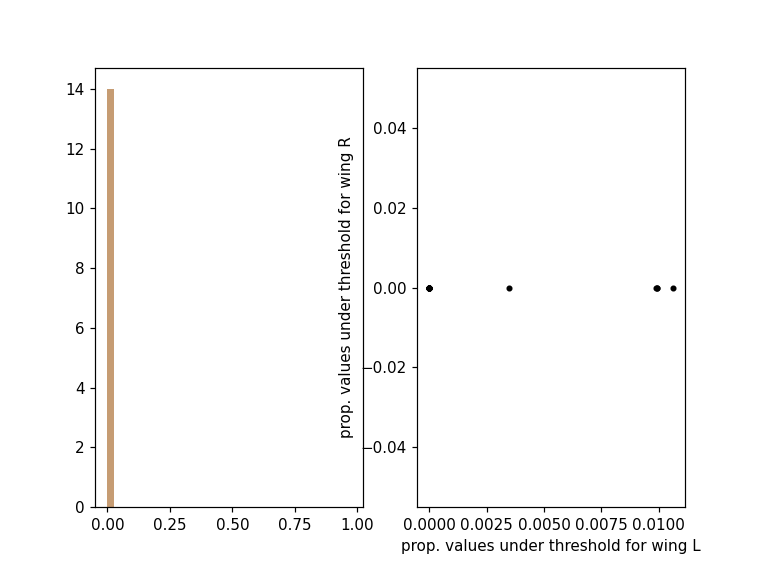

parameters for deciding if wing is beating and detected properly
 theta wing 1: 1.9
theta wing 2: 1.6


Text(0, 0.5, 'prop. values under threshold for wing R')

In [37]:
## VERY SIMPLE METHOD, COUNTING THRESHOLDED VALUES AND THRESHOLD THAT
theta = 0.1
f,ax=plt.subplots(1,2)

print(f'parameters for deciding if wing is beating and detected properly\n theta wing 1: {theta_1}\ntheta wing 2: {theta_2}')
# f,ax=plt.subplots(1,1)
t1= np.array([np.sum(anlyz.segments[i].data[1]<theta_1) for i in range(anlyz.segments.size)])
t2= np.array([np.sum(anlyz.segments[i].data[2] < theta_2) for i in range(anlyz.segments.size)])
segmentLengths = np.array([s.data.shape[1] for s in anlyz.segments])

ax[0].hist(t1/segmentLengths,alpha=0.5, bins=np.arange(0,1,0.025))
ax[0].hist(t2/segmentLengths,alpha=0.5, bins=np.arange(0,1,0.025))

# jitterForPlotting = np.random.rand(len(t1))/2
# ax.plot(t1/segmentLengths+jitterForPlotting,  t2/segmentLengths,'k.')
ax[1].plot(t1/segmentLengths,  t2/segmentLengths,'k.')
ax[1].set_xlabel('prop. values under threshold for wing L')
ax[1].set_ylabel('prop. values under threshold for wing R')

<IPython.core.display.Javascript object>


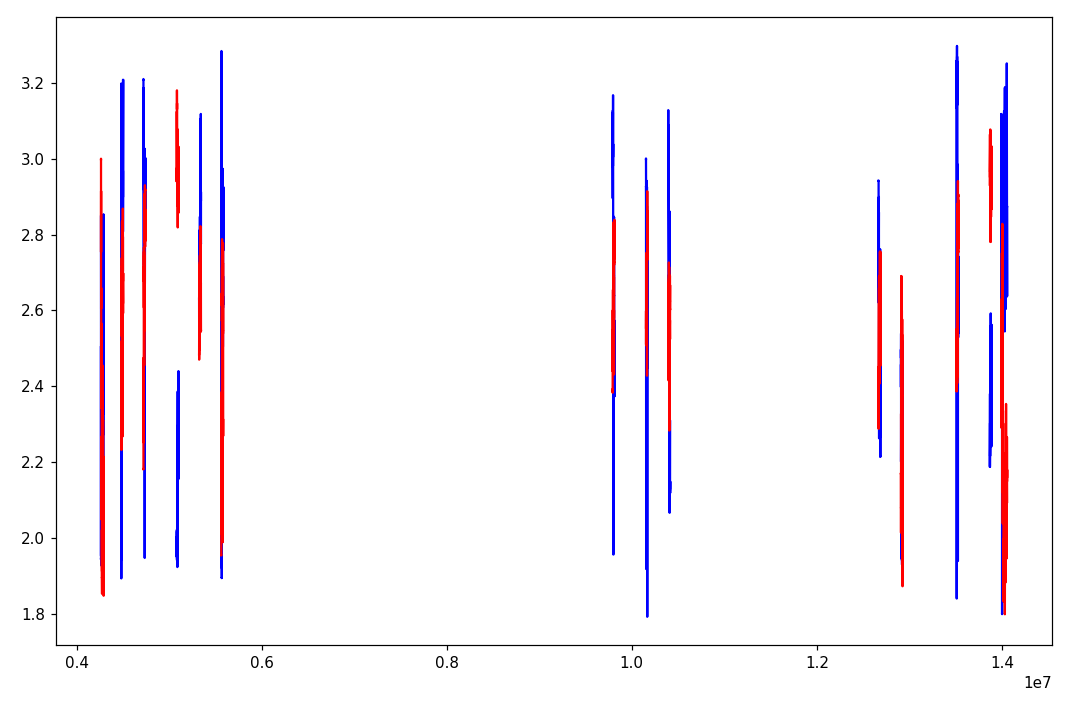

In [38]:
f,ax=plt.subplots(1,1, figsize=(9,6))
[ ax.plot(range(*s.boundaries),s.data[1], 'b-') for s in anlyz.segments ]
[ ax.plot(range(*s.boundaries),s.data[2], 'r-') for s in anlyz.segments ]
#[ ax.plot(range(*s.boundaries),s.data[0], 'g-') for s in anlyz.segments ]
plt.tight_layout()

# Detect Saccades by CWT

## begin by fitting the PWC wingdiff

<IPython.core.display.Javascript object>


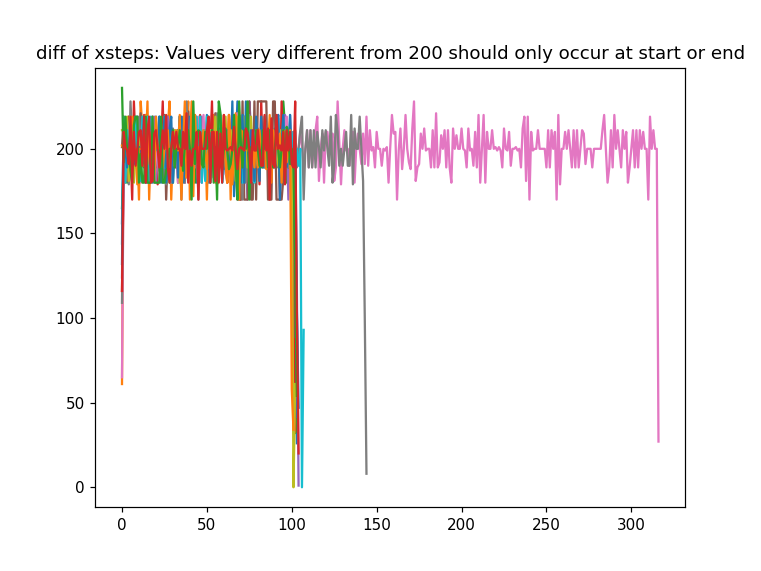

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 1.0, 'diff of xsteps: Values very different from 200 should only occur at start or end')

In [39]:
import helperLibrary

res={}
f,ax=plt.subplots(1,1)
for i,seg in enumerate(anlyz.segments):
    yfit, xsteps, ysteps = helperLibrary.straightLineFiltering(seg.data[anlyz.channelmap['wingDiff']], 0.020*anlyz.samplingRate, postEnhancement=True)
    res[i] = ysteps
    ax.plot(np.diff(xsteps))
ax.set_title('diff of xsteps: Values very different from 200 should only occur at start or end')

In [40]:
pureYvals = res

## function definitions
Several of these are not actually used here, but were developed to reproduce the detection of Kim et al. 2015

In [41]:
def lowPass(y, samplingRate):
    fThresh = 6.#Hz
    #b,a=signal.butter(5,6.,fs=samplingRate, btype='low')
    #ylow = signal.lfilter(b,a,y)
    b,a=signal.butter(5,6.*1.5,fs=samplingRate, btype='low')
    ylow = signal.filtfilt(b,a,y)
    return ylow

def central_diff_derivative(y, halfwidth=0.070, samplPeriod=0.020):
    """y is data to derivate, assumed to be np.array
    halfwidth and samplPeriod shall use the same unit (e.g. seconds)"""
    stepBack = int(halfwidth/samplPeriod+0.5)
    stepFwd = int(halfwidth/samplPeriod)
    return ( y[(stepFwd+stepBack):]-y[:-(stepBack+stepFwd)] )/((stepFwd+stepBack)*samplPeriod)

def highpass_data(y, samplingRate):
    # highpass data
    b,a = signal.butter(5, 1., fs=samplingRate, btype='high')
    yhigh = signal.lfilter(b,a,y)
    return yhigh

def plotHighLowPass(y, yhigh, ylow=None):
    f,ax=plt.subplots(1,1)
    ax.plot(y)
    ax.plot(yhigh)
    if not ylow is None:
        ax.plot(ylow)
    ax.legend(['original','highpass', 'lowpass'])
    return ax

def extractFlyStatistics(y, samplingRate, plot=True, **kwargs):
    yhigh = highpass_data(y, samplingRate)
    pdf, bins = np.histogram(yhigh, bins=50)
    pdf = pdf/pdf.sum()
    cdf = np.cumsum(pdf)
    thresh = kwargs.get('thresh',0.95)
    binCenters = (bins[:-1]+bins[1:])/2

    minIdx = np.argmin(np.abs(cdf-thresh))
    theta = binCenters[minIdx]
    
    if plot:
        f,ax=plt.subplots(1,1)
        ax.plot(binCenters, pdf)
        ax.plot(binCenters, cdf)
        ax.plot(binCenters[minIdx],cdf[minIdx], 'go')
        ax.plot(binCenters[minIdx],pdf[minIdx], 'ro')
        ax.axhline(0.9, color='k', linestyle=':')
        ax.axvline(theta, color='r')
    return theta

def detectPeaks(theta, ydiff):
    detectTheta = theta*6. #as stated in paper
    peaksFound = signal.find_peaks(np.abs(ydiff), height=detectTheta)
    return peaksFound

def plotDetection(ax,ydiff, detectTheta):
    #ax=plt.gca()
    #ax.plot(np.abs(ydiff))
    ax.plot(ydiff)
    ax.axhline(detectTheta, color='k')    
    ax.axhline(0, color='g')
    
# find peak times
def findPeakTimes(ydiff, peaksFound):
    ## for each peak, move FORWARD till encountering closest to 0
    peakTime = np.full_like(peaksFound, np.nan, dtype=int)
    for j,p in enumerate(peaksFound):
        #compare the signs, because peaks can be + or - (at 0 it switches)
        sameSign = True
        i=0
        while sameSign>0:
            i+=1
            if p+i >=ydiff.size:
                i -=1 #plug right value for line after while loop
                break
            sameSign = (ydiff[p+i]*ydiff[p+i-1])>0. 
        if p+i <ydiff.size:
            thisPeak = p+i-1 + np.argmin(np.abs(ydiff[[p+i-1,p+i]]))
        else:
            thisPeak = ydiff.size
        #print(ydiff[[p+i-1,p+i]])
        #print(thisPeak)
        peakTime[j] = int(thisPeak)
    return peakTime

# find onset times
def findOnsetTime(ydiff, peaksFound):
    ## for each peak, move BACKWARD till encountering closest to 0
    onsetTime = np.zeros_like(peaksFound, dtype=int)
    for j,p in enumerate(peaksFound):
        sameSign = True
        i=-0
        while sameSign>0:
            i-=1
            if p+i<0:
                i+=1 #plug right value for line after while loop
                break
            sameSign = (ydiff[p+i]*ydiff[p+i+1])>0. #compare the signs, because peaks can be + or - (at 0 it switches)
        if p+i >=0:
            thisOnset = p+i + np.argmin(np.abs(ydiff[[p+i,p+i+1]]))
        else:
            thisOnset=0
        #print(ydiff[[p+i,p+i+1]])
        #print(thisOnset)
        onsetTime[j] = int(thisOnset)
    return onsetTime

# correct onset times for error introduced by lowpass filtering
def correctOnsetTime(y,ylow, ydiff, peaksFound, onsetTime):
    actualOnset = np.full_like(onsetTime, np.nan, dtype=int)
    for j,o in enumerate(onsetTime):
        ## use value of low-passed L-R WBA at putative onset as threshold
        thresh = ylow[o]
        ## look forward in original signal from putative onset and find last sample before threshold
        ytemp = y-thresh #this turns it into finding a 0-crossing (like above)
        ### shortcut to deal with cases where actual onset is not included in trace
        p = peaksFound[j]
        if not any(np.diff(np.sign(ytemp[o:p]))):
            #no change in sign means no threshold crossing
            actualOnset[j] = o #keep putataive one
            continue
        sameSign=True
        i=0
        while sameSign:
            i+=1
            #sameSign = (ydiff[o+i]*ydiff[o+i-1])>0.
            sameSign = (ytemp[o+i]*ytemp[o+i-1])>0.
        ## define this as actual onset
        actualOnset[j] = o+1-1
    return actualOnset

## get saccade amplitudes
def getSaccadeAmplitude(y, peaksFound, actualOnset, samplingRate):
    #subtracted the mean L-R WBA signal 50-ms baseline interval before saccade onset 
    #from mean L-R WBA signal in +-15-ms windows surrounding the peak
    saccAmp = np.full(peaksFound.size, np.nan, dtype=np.float)
    for i in range(len(actualOnset)):
        baseline = np.mean(y[actualOnset[i]-int(0.06*samplingRate) : actualOnset[i]])
        if not np.isnan(baseline):
            #saccAmp[i] =  np.mean( y[peaksFound[i]-int(0.03*samplingRate) : peaksFound[i]+int(0.03*samplingRate)+1] ) - baseline    
            saccAmp[i] =  np.mean( y[peaksFound[i]-int(0.03*samplingRate) : peaksFound[i]+int(0.03*samplingRate)] ) - baseline    
    return saccAmp

def plotPeaks(y, actualOnset, peakTime, saccAmp, ax=None):
    if ax is None:
        f,ax=plt.subplots(1,1)
        ax.plot(y)
    ax.plot(actualOnset, y[actualOnset], 'r>')
    ax.plot(peakTime, y[peakTime], 'k^')
    ax.plot(peakTime, saccAmp, 'ko')
    return

# eliminate putative saccade if maximal deviation before onset is>55% of amplitude
def eliminateByDeviation(y, actualOnset, saccAmp, samplingRate, **kwargs):
    window = kwargs.get('window',0.201)
    deviationLimit = kwargs.get('deviationLimit',0.55)
    toEliminate = []
    for i in range(actualOnset.size):
        # preselect to make sure the indexing is feasible
        #baseline = np.mean(y[actualOnset[i]-int(0.2*samplingRate) : actualOnset[i]])
        chunk = y[actualOnset[i]-int(window*samplingRate) : actualOnset[i]]
        if actualOnset[i]-int(window*samplingRate) <0:
            toEliminate.append(i)
            continue
        deviation = chunk.max()-chunk.min()
        if deviation>deviationLimit*abs(saccAmp[i]):
            toEliminate.append(i)
    return toEliminate


In [42]:
def eliminateByPeakProximity(onset, peakTime,*, samplingRate=10000, timeDist:float=0.5) ->list:
    '''eliminate peaks that are too close too one another. 
    This is intended particularly for when they go in opposite direction, 
    such that the second could well be end of the first
    Note: we don't need absolute times because operating inside segments
    This is instance one, measuring distance peak-to-onset'''
    #make sure they are sorted
    onset.sort()
    peakTime.sort()
    # iterate forward, check distance to previous 
    toEliminate = []
    for i in range(1,onset.size):
        current=onset[i]
        prev = peakTime[i-1]
        # if it's too short, eliminate
        if current-prev < timeDist*samplingRate :
            toEliminate.append(i)
    return toEliminate

def eliminateByPeakProximity2(onset,*, samplingRate=10000, timeDist:float=0.5) ->list:
    '''eliminate peaks that are too close to one another. 
    This is intended particularly for when they go in opposite direction, 
    such that the second could well be end of the first
    Note: we don't need absolute times because operating inside segments
    This is instance two, measuring distance onset-to-onset'''
    #make sure they are sorted
    onset.sort()
    peakTime.sort()
    # iterate forward, check distance to previous 
    toEliminate = []
    for i in range(1,onset.size):
        current=onset[i]
        prev = onset[i-1]
        # if it's too short, eliminate
#         if not (current-prev)>0:
#             print('weird stuff here ',current, prev)
        assert(not current-prev<0)
        if current-prev < timeDist*samplingRate :
            toEliminate.append(i)
    return toEliminate

def eliminateByPeakProximity3(onset,saccAmp,*, samplingRate=10000, timeDist:float=0.5) ->list:
    '''eliminate peaks that are too close to one another. 
    This is intended particularly for when they go in opposite direction, 
    such that the second could well be end of the first
    Note: we don't need absolute times because operating inside segments
    This is instance three, considering only distances between saccades if they are in opposite directions'''
    #make sure they are sorted
    onset.sort()
    peakTime.sort()
    # iterate forward, check distance to previous 
    toEliminate = []
    for i in range(1,onset.size):
        if saccAmp[i]*saccAmp[i-1] >0:#sign check, same saccade direction
            continue
        current=onset[i]
        prev = onset[i-1]
        # if it's too short, eliminate
#         if not (current-prev)>0:
#             print('weird stuff here ',current, prev)
        assert(not current-prev<0)
        if current-prev < timeDist*samplingRate :
            toEliminate.append(i)
    return toEliminate

def eliminateByPeakProximity4(onset,peakTime,saccAmp,*, samplingRate=10000, timeDist:float=0.5) ->list:
    '''eliminate peaks that are too close to one another. 
    This is intended particularly for when they go in opposite direction, 
    such that the second could well be end of the first
    Note: we don't need absolute times because operating inside segments
    This is instance three, considering only distances between saccades if they are in opposite directions'''
    #make sure they are sorted
    onset.sort()
    peakTime.sort()
    # iterate forward, check distance to previous 
    toEliminate = []
    for i in range(1,onset.size):
        if saccAmp[i]*saccAmp[i-1] >0:#sign check, same saccade direction
            continue
        current=onset[i]
        prev = peakTime[i-1]
        # if it's too short, eliminate
#         if not (current-prev)>0:
#             print('weird stuff here ',current, prev)
#         assert(not current-prev<0)#problkem with this assertion
        if current-prev < timeDist*samplingRate :
            toEliminate.append(i)
    return toEliminate

def eliminateBySaccAmplitude(saccAmp, thresh)->list:
    toEliminate=[]
    for i in range(0,saccAmp.size):
        if abs(saccAmp[i])< thresh:
            toEliminate.append(i)
    return toEliminate

def eliminatePutativePersistent(cwtpeaks,peakTime,maxPeakDelay,onset,maxOnsetDelay, samplingPeriod):
    # eliminate if the onset or peak are too far away from the peak in derivative
    toEliminate = []
    for i in range(cwtpeaks.size):
        if cwtpeaks[i]-onset[i]>maxOnsetDelay/samplingPeriod:#don't know yet how big this hsould be
            toEliminate.append(i)
        elif peakTime[i]-cwtpeaks[i]>maxPeakDelay/samplingPeriod:
            toEliminate.append(i)
    return toEliminate

## CWT approach

<IPython.core.display.Javascript object>


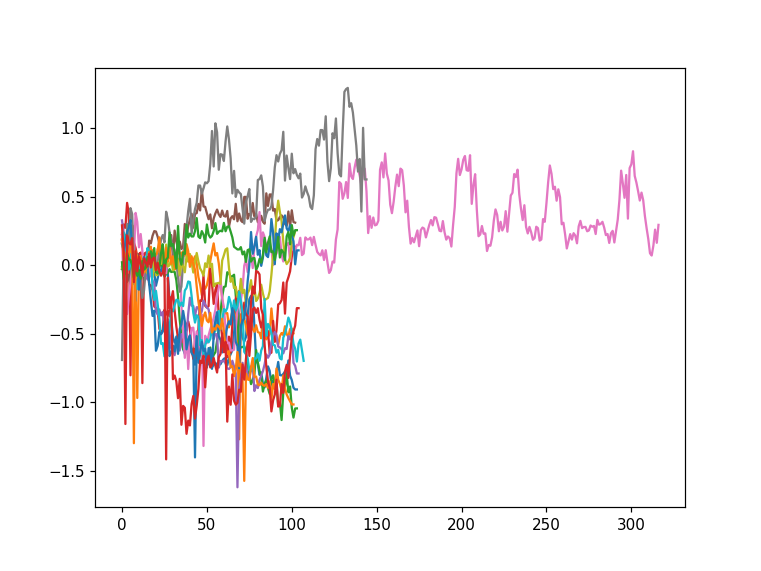

In [43]:
f,ax=plt.subplots(1,1)
for i in pureYvals:
    ax.plot(pureYvals[i])

### compare find_peaks_cwt using different scale vectors

Here, I made several side-by-side comparisons of parameter variations

### detection

In [44]:
# get a random sample of trials to plot (visually inspect)
plotIdx = sorted(np.random.choice(np.arange(anlyz.segments.size), 6, replace=False))
plotIdx=np.append(plotIdx, anlyz.segments.size)#append a number that will never be reached later
#plotIdx=np.array([0,1,2,3,4,5,6,7,500])
plotIdx

array([ 3,  5,  6,  9, 11, 12, 14])

<IPython.core.display.Javascript object>


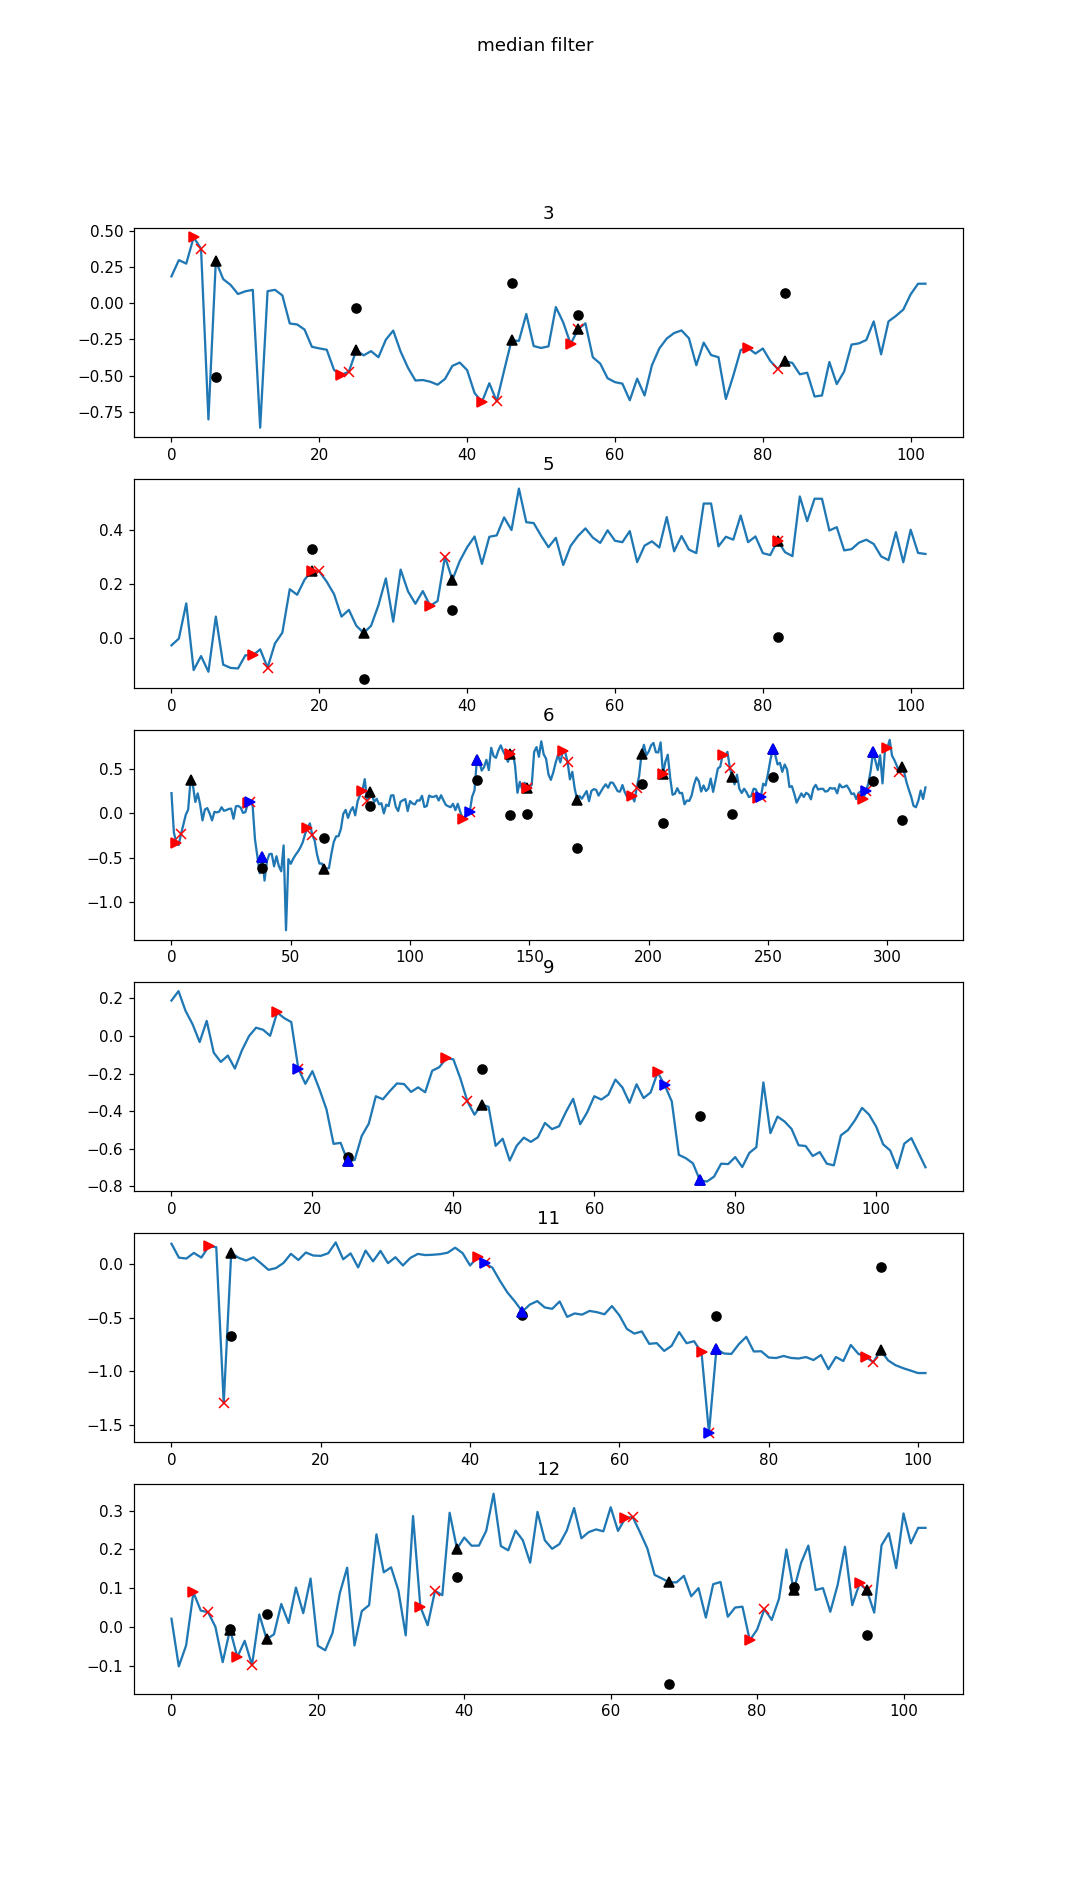

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you

Text(0.5, 0.98, 'median filter')

In [68]:
saccDataCWT = {}

# scales = 2.**np.arange(1.5, 3., 1./16.)
scales = 2.**np.arange(2, 3., 1./16.)
diff_half_width = 0.05 #0.05
medianFilterWidth = 3
cwtpeaks_window_size = 20
deviationWindow = 0.16 #0.16
deviationLimit = 0.65 # was 0.55 for spont
saccAmpThreshold = 20.*np.pi/180
minPeakInterval = 0.5
cascadeFiltering = True
maxPeakDelay = 0.2#s
maxOnsetDelay =  0.1#s

#f,ax=plt.subplots(5,2)
f,ax=plt.subplots(6,1, figsize=(9,16))
ax=ax.reshape(-1,1)
#start=0
pltix=0
#for i in range(start,start+5):
for i in range(anlyz.segments.size):
#for i in [0]:
    if not i in pureYvals.keys():    continue
    y=pureYvals[i]
    detectSignal = signal.medfilt(y,medianFilterWidth)
    #detectSignal=np.diff(detectSignal)
    detectSignal = central_diff_derivative(detectSignal, diff_half_width, 0.02)
    #peaks = signal.find_peaks_cwt(detectSignal, scales, gap_thresh=1, window_size=20, noise_p=5)
    peaks = signal.find_peaks_cwt(detectSignal, scales, gap_thresh=1, 
                                  window_size=cwtpeaks_window_size, noise_perc=5)
    peaks2 = signal.find_peaks_cwt(-detectSignal, scales, gap_thresh=1, 
                                   window_size=cwtpeaks_window_size, noise_perc=5)
    peaks = np.concatenate((peaks,peaks2))
    peaks.sort() #sorts in-place
    peaks = peaks.astype('int')
#     print(f'Starting with {peaks.size} peaks')
    peakTime = findPeakTimes(np.diff(signal.medfilt(y,medianFilterWidth)), peaks)
#     peakTime = findPeakTimes(detectSignal, peaks)+int(diff_half_width/anlyz.kineflyPeriod)
    onsetTime = findOnsetTime(np.diff(signal.medfilt(y,medianFilterWidth)), peaks)
    saccAmp = getSaccadeAmplitude(y, peakTime, onsetTime, 1/anlyz.kineflyPeriod)

    # plot detection before filtering
    if i==plotIdx[pltix]:
        ax[pltix,0].plot(y)
        #ax[i-start,0].plot(detectSignal)
        ax[pltix,0].plot(peaks, y[peaks], 'rx')
        #ax[i-start,0].plot(peaks, detectSignal[peaks], 'kx')
        #im=ax[i-start,1].pcolormesh(c)
        #im.set_clim([-0.5,0.5])

        ax[pltix,0].plot(peakTime, y[peakTime], 'k^')
        ax[pltix,0].plot(onsetTime, y[onsetTime], 'r>')
        ax[pltix,0].plot(peakTime, saccAmp, 'ko')

    #start filtering stage
    keep = np.ones_like(peaks,dtype=bool)
    elim = eliminateBySaccAmplitude(saccAmp, saccAmpThreshold)
    keep[elim]=False
#     print(f'eliminating {len(elim)} elements in this step')
    if cascadeFiltering:
        peaks = peaks[keep]
        peakTime = peakTime[keep]
        onsetTime = onsetTime[keep]
        saccAmp = saccAmp[keep]
        keep = np.ones_like(peaks,dtype=bool)
    
    #elim = eliminateByPeakProximity(onsetTime, peakTime, samplingRate=anlyz.kineflyPeriod, timeDist=0.2)
#     elim = eliminateByPeakProximity2(onsetTime, samplingRate=1/anlyz.kineflyPeriod, timeDist=minPeakInterval)
    elim = eliminateByPeakProximity3(onsetTime, saccAmp, samplingRate=1/anlyz.kineflyPeriod,
                                     timeDist=minPeakInterval)
#     elim = eliminateByPeakProximity4(onsetTime,peakTime, saccAmp, samplingRate=1/anlyz.kineflyPeriod,
#                                      timeDist=minPeakInterval)
    keep[elim]=False
#     print(f'eliminating {len(elim)} elements in this step')
    #combine with next step
#     if cascadeFiltering:
#         peaks = peaks[keep]
#         peakTime = peakTime[keep]
#         onsetTime = onsetTime[keep]
#         saccAmp = saccAmp[keep]
#         keep = np.ones_like(peaks,dtype=bool)
    #these two steps are similar, therefore combine together
    elim = eliminateByDeviation(y, onsetTime, saccAmp, 1/anlyz.kineflyPeriod, 
                                window=deviationWindow, deviationLimit=deviationLimit)
    keep[elim]=False
#     print(f'eliminating {len(elim)} elements')
    if cascadeFiltering:
        peaks = peaks[keep]
        peakTime = peakTime[keep]
        onsetTime = onsetTime[keep]
        saccAmp = saccAmp[keep]
        keep = np.ones_like(peaks,dtype=bool)
    
    
    elim = eliminatePutativePersistent(peaks, peakTime,maxPeakDelay, onsetTime,maxOnsetDelay, anlyz.kineflyPeriod)
    keep[elim]=False
#     print(f'eliminating {len(elim)} elements in this step')
    
    #theta = extractFlyStatistics(y, 1/anlyz.kineflyPeriod, plot=False)
    #print(theta)

    if i==plotIdx[pltix]:
#         ax[pltix,0].plot(y)
#         #ax[i-start,0].plot(detectSignal)
#         ax[pltix,0].plot(peaks, y[peaks], 'rx')
#         #ax[i-start,0].plot(peaks, detectSignal[peaks], 'kx')
#         #im=ax[i-start,1].pcolormesh(c)
#         #im.set_clim([-0.5,0.5])

#         ax[pltix,0].plot(peakTime, y[peakTime], 'k^')
#         ax[pltix,0].plot(onsetTime, y[onsetTime], 'r>')
#         ax[pltix,0].plot(peakTime, saccAmp, 'ko')
        ax[pltix,0].plot(peaks[keep], y[peaks[keep]], '>',color='b',markerfacecolor=None)
        ax[pltix,0].plot(peakTime[keep], y[peakTime[keep]], '^',color='b',markerfacecolor=None)
        ax[pltix,0].set_title(plotIdx[pltix])
        pltix += 1

    peaks = peaks[keep]
    peakTime = peakTime[keep]
    onsetTime = onsetTime[keep]
    saccAmp = saccAmp[keep]
    
    saccDataCWT[i] = dict([('peakTime',peakTime),('onset',onsetTime), ('saccAmp',saccAmp), ('CWTpeaks',peaks)])
detectionParams = {'method':'CWT',
                  'scales': scales,
                  'diff_half_width': diff_half_width,
                  'medianFilterWidth': medianFilterWidth,
                  'CWTpeaks_window_size':cwtpeaks_window_size,
                   'deviationWindow':deviationWindow,
                   'deviationLimit': deviationLimit,
                   'saccAmpThreshold': saccAmpThreshold,
                   'minPeakInterval':minPeakInterval,
                   'maxPeakDelay': maxPeakDelay,
                   'maxOnsetDelay': maxOnsetDelay,
                   'cascadeFiltering': cascadeFiltering
                  }
f.suptitle('median filter')

### plot

In [69]:
saccDataCWT

{0: {'peakTime': array([], dtype=int32),
  'onset': array([], dtype=int32),
  'saccAmp': array([], dtype=float64),
  'CWTpeaks': array([], dtype=int32)},
 1: {'peakTime': array([], dtype=int32),
  'onset': array([], dtype=int32),
  'saccAmp': array([], dtype=float64),
  'CWTpeaks': array([], dtype=int32)},
 2: {'peakTime': array([36]),
  'onset': array([30]),
  'saccAmp': array([-0.51920573]),
  'CWTpeaks': array([32])},
 3: {'peakTime': array([], dtype=int32),
  'onset': array([], dtype=int32),
  'saccAmp': array([], dtype=float64),
  'CWTpeaks': array([], dtype=int32)},
 4: {'peakTime': array([], dtype=int32),
  'onset': array([], dtype=int32),
  'saccAmp': array([], dtype=float64),
  'CWTpeaks': array([], dtype=int32)},
 5: {'peakTime': array([], dtype=int32),
  'onset': array([], dtype=int32),
  'saccAmp': array([], dtype=float64),
  'CWTpeaks': array([], dtype=int32)},
 6: {'peakTime': array([ 38, 128, 252, 294]),
  'onset': array([ 32, 122, 246, 290]),
  'saccAmp': array([-0.6120

<IPython.core.display.Javascript object>


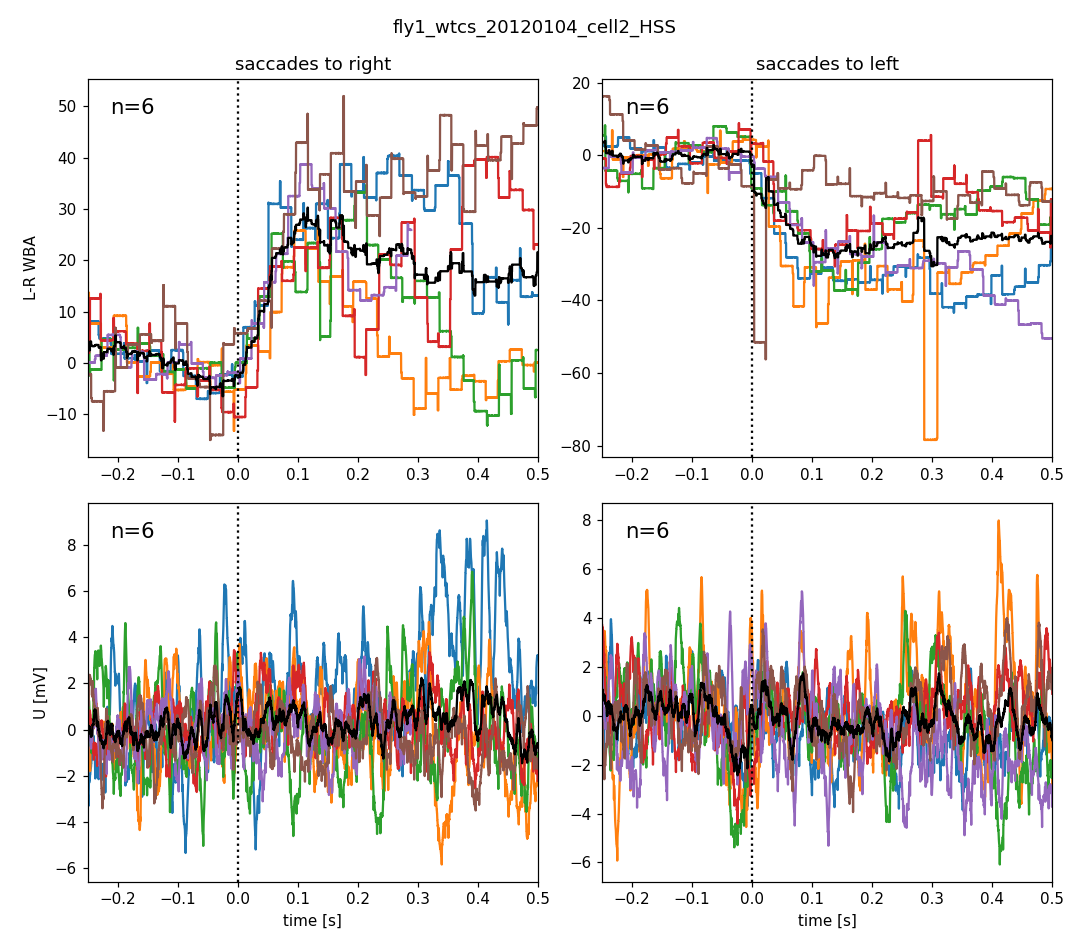

In [70]:
allLeft = []
allRight = []

f,ax=plt.subplots(2,2, figsize=(9,8))
# for el in range(11,12):
for el in range(len(anlyz)):
    #if not el in pureYvals.keys():   continue
    if not isinstance(saccDataCWT[el]['peakTime'], (list,np.ndarray)):
        saccDataCWT[el] = {k:np.array([v]) for k,v in saccDataCWT[el].items()}
    if len(saccDataCWT[el]['peakTime'])==0:  continue
    v = saccDataCWT[el]
    #actualOnset= (v['onset']*anlyz.meanFramePeriod*anlyz.samplingRate).astype(int)
    actualOnset= (v['CWTpeaks']*0.02*anlyz.samplingRate).astype(int)
    #pdb.set_trace()
    saccAmp = v['saccAmp']
    rightSacc = []
    leftSacc=[]
    #chunk = int(0.5*anlyz.samplingRate)
    chunk = int(0.5*anlyz.samplingRate)
    preOnset = int(0.25*anlyz.samplingRate)
    ephys = anlyz.segments[el].data[0]#ephys data
    wba = anlyz.segments[el].data[-1]*180/np.pi
    #f,ax=plt.subplots(2,1, figsize=(10,4))
    #ax[0].plot(wba)
    #ax[1].plot(ephys)
    #for o,a in zip(actualOnset, saccAmp):
    for j in range(saccAmp.size):
        o=actualOnset[j]
        a=saccAmp[j]
        p= (v['peakTime']*0.02*anlyz.samplingRate).astype(int)[j]
        #ax[0].plot(o,wba[o], 'r>')
        #ax[0].plot(p, wba[p],'k^' )
        #xval = np.arange(o-preOnset, o+chunk)/anlyz.samplingRate
        if a<0:
            leftSacc.append(ephys[o-preOnset:o+chunk])
            #leftSacc.append(ephys[o-preOnset:p+chunk])
            d = wba[o-preOnset:o+chunk]
            xval = np.arange(-preOnset, d.size-preOnset)/anlyz.samplingRate
            ax[0,1].plot(xval, d-np.mean(d[:int(0.25*anlyz.samplingRate)]))#have to adjust this for PWC-fitted data
            d = ephys[o-preOnset:o+chunk]
            ax[1,1].plot(xval, d-np.mean(d[:int(0.25*anlyz.samplingRate)]))
        else:
            rightSacc.append(ephys[o-preOnset:o+chunk])
            #rightSacc.append(ephys[o-preOnset:p+chunk])
            d = wba[o-preOnset:o+chunk]
            xval = np.arange(-preOnset,d.size-preOnset)/anlyz.samplingRate
            ax[0,0].plot(xval, d-np.mean(d[:int(0.25*anlyz.samplingRate)]))#have to adjust this for PWC-fitted data
            d = ephys[o-preOnset:o+chunk]
            ax[1,0].plot(xval, d-np.mean(d[:int(0.25*anlyz.samplingRate)]))
    allLeft.extend(leftSacc)
    allRight.extend(rightSacc)
ax[0,0].set_title('saccades to right')
ax[0,1].set_title('saccades to left')
ax[0,0].set_ylabel('L-R WBA')
ax[1,0].set_ylabel('U [mV]')
ax[1,0].set_xlabel('time [s]')
ax[1,1].set_xlabel('time [s]')
#ax[0,0].set_ylim([-0.15, 0.51])
#ax[0,1].set_ylim([-0.51, 0.15])
#ax[1,0].set_ylim([-4, 4])
#ax[1,1].set_ylim([-4, 4])
#ax[0,0].set_ylim([-0.21, 0.45])
[a.set_xlim([-0.25,0.5]) for a in ax.flatten()]

[a.axvline(0., color='k', linestyle=':') for a in ax.flatten()]    

# post-hoc adding a mean
i=0
for a in ax.flatten():
    ally=[c.get_data()[1] for c in a.get_children() if isinstance(c, plt.Line2D)]
    ally=[y for y in ally if len(y)>100]
    #print([len(y) for y in ally])
    try:
        minLen = min([len(y) for y in ally])
    #     padLen = int(np.median([len(y) for y in ally])) # !why median!?
        padLen = int(np.max([len(y) for y in ally]))
        #print(minLen)
        ally = [np.pad(y,(0,padLen-len(y)), mode='constant', constant_values=np.nan) for y in ally]
        #ally = np.array([y[:minLen] for y in ally])
        ally = np.array(ally)
        a.plot(np.arange(-preOnset,ally.shape[1]-preOnset)/anlyz.samplingRate, np.nanmean(ally,axis=0), 'k-')

    #     mu = np.nanmean(ally,axis=0)
    #     a.plot(np.arange(-preOnset,ally.shape[1]-preOnset)/anlyz.samplingRate, (mu-np.nanmean(mu))/np.nanstd(mu), 'r-')

        if i==0:
            anlyz.saccRightMeanWBA = np.nanmean(ally,axis=0)
        elif i==1:
            anlyz.saccLeftMeanWBA = np.nanmean(ally,axis=0)
        elif i==2:
            anlyz.saccRightMeanEphys = np.nanmean(ally,axis=0)
        elif i==3:
            anlyz.saccLeftMeanEphys = np.nanmean(ally,axis=0)
        i+=1
    except ValueError: #if min() arg is an empty sequence
        ally = np.zeros(0)
        
    #a.set_xlim([-preOnset,padLen/anlyz.samplingRate])
    a.text(0.05, 0.95, f'n={ally.shape[0]}', transform=a.transAxes, fontsize=14,
    verticalalignment='top')

f.suptitle(anlyz.flyID[0]+'_'+anlyz.metadata[0]['HS_type'])
plt.tight_layout()

In [71]:
print(detectionParams)

{'method': 'CWT', 'scales': array([4.        , 4.17709513, 4.36203093, 4.55515454, 4.75682846,
       4.96743125, 5.18735822, 5.41702219, 5.65685425, 5.90730458,
       6.1688433 , 6.44196133, 6.72717132, 7.02500864, 7.33603235,
       7.66082625]), 'diff_half_width': 0.05, 'medianFilterWidth': 3, 'CWTpeaks_window_size': 20, 'deviationWindow': 0.16, 'deviationLimit': 0.65, 'saccAmpThreshold': 0.3490658503988659, 'minPeakInterval': 0.5, 'maxPeakDelay': 0.2, 'maxOnsetDelay': 0.1, 'cascadeFiltering': True}


### save results

In [72]:
anlyz.flyID

{0: 'fly1_wtcs_20120104_cell2'}

In [73]:
f.savefig(os.path.join(DATAPATH,'spontaneousSaccades','oldData',
                       'CWTdetection', anlyz.flyID[0]+'_oldData_spontSaccades.png' ))
f.savefig(os.path.join(DATAPATH,'spontaneousSaccades','oldData',
                       'CWTdetection', anlyz.flyID[0]+'_oldData_spontSaccades.svg' ))

In [74]:
# split into saccades left and right
# make use of the mechanism for splitting flying or not
anlyz.saccades = saccDataCWT
anlyz.write2neomatfile(os.path.join(DATAPATH,'spontaneousSaccades','oldData',
                            'CWTdetection', anlyz.flyID[0]+'_oldData_spontSaccades_cwtDetection.neomat'))


### quality control: plot saccades over time

## plot saccades in whole record context

In [57]:
# load original file if necessary
try:
    loader
    assert(loader.file==anlyz.fileOrigin[0])
except (NameError, AssertionError): #if loader doesn't exist
    loader = bc.DataLoader(anlyz.fileOrigin[0])
print(loader.file)
print(anlyz.flyID)

D:\RecorderData\vonBettina\oldHSdata_adaptedFormat\fly1_wtcs_age_na_cell1_HSS_2013_02_11_00_00_00.mat
{0: 'fly1_wtcs_20130211_cell1'}


In [58]:
colorSaccLeft = 'g'
colorSaccRight = 'y'

# saccDataCWT = anlyz.saccades

<IPython.core.display.Javascript object>


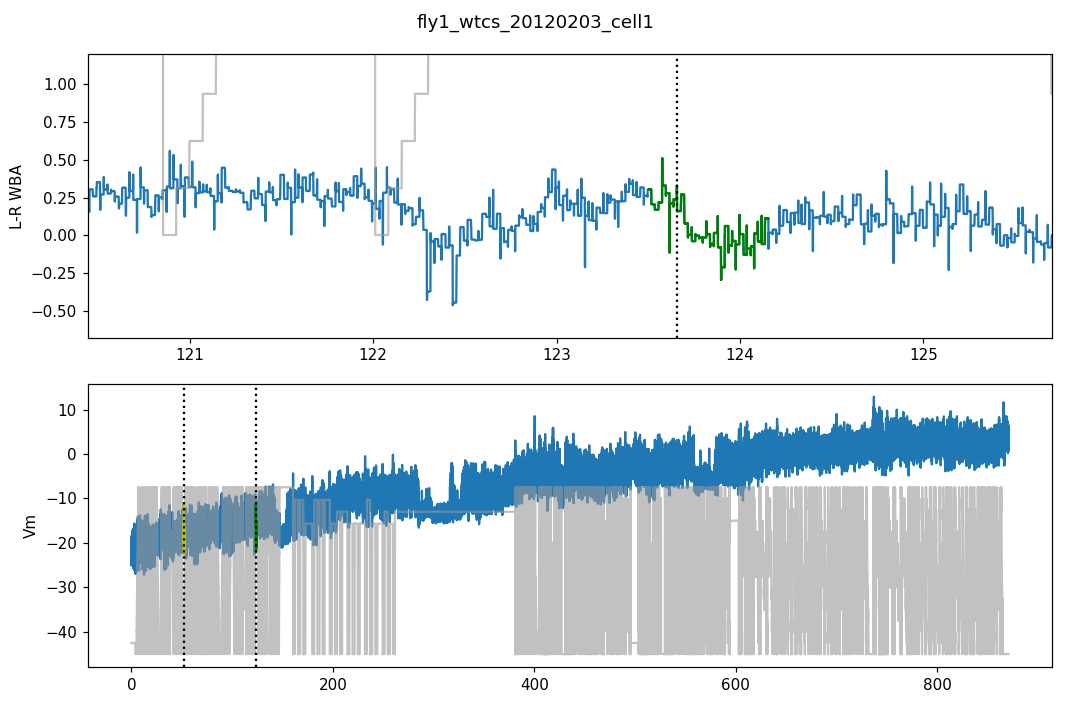

In [715]:
allWBA = loader.data[1]-loader.data[2]
allEphys = loader.data[0]
reductionFactor = 10

f,ax=plt.subplots(2,1, figsize=(9,6))
timeax = np.arange(0,loader.data.shape[1],reductionFactor)/anlyz.samplingRate
ax[0].plot(timeax, allWBA[::reductionFactor])
ax[1].plot(timeax, allEphys[::reductionFactor])
ax[0].plot(timeax, loader.data[3,::reductionFactor], color=[.6,.6,.6], alpha=.6)
ax[1].plot(timeax, loader.data[3,::reductionFactor]*8-45, color=[.6,.6,.6], alpha=.6)


for el in range(len(anlyz)):
    #if not el in pureYvals.keys():   continue
    if not isinstance(saccDataCWT[el]['peakTime'], (list,np.ndarray)):
        saccDataCWT[el] = {k:np.array([v]) for k,v in saccDataCWT[el].items()}
    if len(saccDataCWT[el]['peakTime'])==0:  continue
    v = saccDataCWT[el]
    #actualOnset= (v['onset']*anlyz.meanFramePeriod*anlyz.samplingRate).astype(int)
    actualOnset= (v['CWTpeaks']*0.02*anlyz.samplingRate).astype(int)
    #pdb.set_trace()
    saccAmp = v['saccAmp']
    chunk = int(0.5*anlyz.samplingRate)
    preOnset = int(0.15*anlyz.samplingRate)
    for j in range(saccAmp.size):
        p= (v['peakTime']*0.02*anlyz.samplingRate).astype(int)[j]
        if saccAmp[j]<0:
            plotColor=colorSaccLeft
        else:
            plotColor=colorSaccRight
        xval = np.arange(-preOnset, chunk)#/anlyz.samplingRate
        xval += actualOnset[j]
        xval += anlyz.segments[el].boundaries[0]
        xval = xval.astype(int)
        ax[0].plot(xval/anlyz.samplingRate, allWBA[xval], color=plotColor)
        ax[1].plot(xval/anlyz.samplingRate, allEphys[xval], color=plotColor)
        ax[0].axvline((actualOnset[j]+anlyz.segments[el].boundaries[0])/anlyz.samplingRate, linestyle=':',color='k')
        ax[1].axvline((actualOnset[j]+anlyz.segments[el].boundaries[0])/anlyz.samplingRate, linestyle=':',color='k')
f.suptitle(anlyz.flyID[0])
ax[0].set_ylabel('L-R WBA')
ax[1].set_ylabel('Vm')
# ax[0].set_xlim([0, loader.data.shape[1]])
# ax[1].set_xlim([0, loader.data.shape[1]])
plt.tight_layout()

# compile contingency table and try statistical test

<table>
  <tr>
    <th></th>
    <th>deviation from 0</th>
    <th>no deviation</th>
    <th>$\Sigma$</th>
  </tr>
  <tr>
    <td>HSN</td>
    <td>6</td>
    <td>2</td>
    <td>8</td>
  </tr>
  <tr>
    <td>not HSN</td>
    <td>5</td>
    <td>13</td>
    <td>18</td>
  </tr>
  <tr>
    <td>$\Sigma$</td>
    <td>11</td>
    <td>15</td>
    <td>26</td>
  </tr>
</table>

In [6]:
stats.boschloo_exact(np.array(
    [[6,2],
     [5,13]]
    ), 'two-sided')

BoschlooExactResult(statistic=0.03432494279176202, pvalue=0.041110519250345576)

## rephrased question

<table>
  <tr>
    <th></th>
    <th>as found by Maimon</th>
    <th>contrary to expectation</th>
    <th>$\Sigma$</th>
  </tr>
  <tr>
    <td>HSN</td>
    <td>6</td>
    <td>2</td>
    <td>8</td>
  </tr>
  <tr>
    <td>not HSN</td>
    <td>1</td>
    <td>16</td>
    <td>17</td>
  </tr>
  <tr>
    <td>$\Sigma$</td>
    <td>7</td>
    <td>18</td>
    <td>25</td>
  </tr>
</table>

In [193]:
print("Fisher's test") #actually not the right test in this situation
print(stats.fisher_exact(np.array(
    [[6,2],
     [1,16]]
    ), 'two-sided')
     )

print("Boschloo's test")
print(
stats.boschloo_exact(np.array(
    [[6,2],
     [1,16]]
    ), 'two-sided')
)

Fisher's test
(48.0, 0.0010068649885583536)
Boschloo's test
BoschlooExactResult(statistic=0.0010068649885583536, pvalue=0.0006814525258507462)


# gather results

## load

In [7]:
import glob

In [8]:
flist = glob.glob(os.path.join(DATAPATH,'spontaneousSaccades','oldData','CWTdetection','*.neomat'))
flist.extend([os.path.join(DATAPATH,'spontaneousSaccades','CWTdetection',
      f'{fn}_looming_wb_spontSaccades_cwtDetection.neomat') 
     for fn in ('fly4_x21_20200420_cell1', 
                'fly3_x21_20200415_cell1', 
                'fly3_x21_20200417_cell1')]) # missing 2020_09_30
flist

['D:\\RecorderData\\spontaneousSaccades\\oldData\\CWTdetection\\fly1_wtcs_20111222_cell1_oldData_spontSaccades_cwtDetection.neomat',
 'D:\\RecorderData\\spontaneousSaccades\\oldData\\CWTdetection\\fly1_wtcs_20120104_cell1_oldData_spontSaccades_cwtDetection.neomat',
 'D:\\RecorderData\\spontaneousSaccades\\oldData\\CWTdetection\\fly1_wtcs_20120104_cell2_oldData_spontSaccades_cwtDetection.neomat',
 'D:\\RecorderData\\spontaneousSaccades\\oldData\\CWTdetection\\fly1_wtcs_20120105_cell1_oldData_spontSaccades_cwtDetection.neomat',
 'D:\\RecorderData\\spontaneousSaccades\\oldData\\CWTdetection\\fly1_wtcs_20120105_cell2_oldData_spontSaccades_cwtDetection.neomat',
 'D:\\RecorderData\\spontaneousSaccades\\oldData\\CWTdetection\\fly1_wtcs_20120207_cell1_oldData_spontSaccades_cwtDetection.neomat',
 'D:\\RecorderData\\spontaneousSaccades\\oldData\\CWTdetection\\fly1_wtcs_20120217_cell1_oldData_spontSaccades_cwtDetection.neomat',
 'D:\\RecorderData\\spontaneousSaccades\\oldData\\CWTdetection\\fly1_

<IPython.core.display.Javascript object>


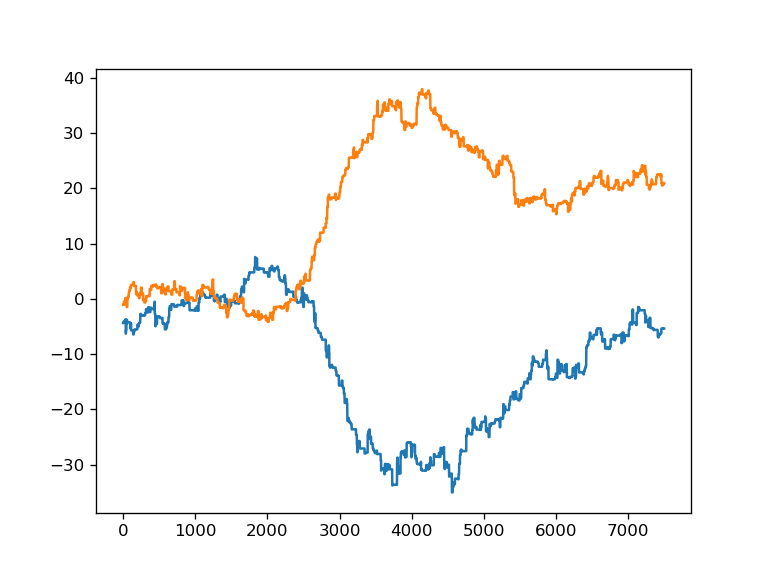

In [11]:
fn=flist[0]
da = DummyAnalyzer.retrieveFromNeomatfile(fn)
f,ax=plt.subplots(1,1)
ax.plot(da.saccLeftMeanWBA)
ax.plot(da.saccRightMeanWBA)

In [12]:
allSaccLeftMeanEphys = {}
allSaccLeftMeanWBA = {}
allSaccRightMeanEphys = {}
allSaccRightMeanWBA = {}

for fn in flist[:]:
    da = DummyAnalyzer.retrieveFromNeomatfile(fn)
    if 'oldData' not in fn:
        print('multiplying WBA at',fn)
        da.saccLeftMeanWBA *= (180/np.pi)
        da.saccRightMeanWBA *= (180/np.pi)
    else:
        da.saccLeftMeanWBA /= 1.7
        da.saccRightMeanWBA /= 1.7
    if max(abs(da.saccLeftMeanEphys)) <0.1:
        print('multiplying Vm at',fn)
        da.saccLeftMeanEphys *= 100.
        da.saccRightMeanEphys *= 100.
    if abs(da.samplingRate -10000) >10:
        raise Exception('unexpected sampling rate')
#         da.saccLeftMeanEphys = signal.resample(da.saccLeftMeanEphys, int(da.saccLeftMeanEphys.size/da.samplingRate*10000.))
#         da.saccRightMeanEphys = signal.resample(da.saccRightMeanEphys, int(da.saccRightMeanEphys.size/da.samplingRate*10000.))
#         da.saccLeftMeanWBA = signal.resample(da.saccLeftMeanWBA, int(da.saccLeftMeanWBA.size/da.samplingRate*10000.))
#         da.saccRightMeanWBA = signal.resample(da.saccRightMeanWBA, int(da.saccRightMeanWBA.size/da.samplingRate*10000.))
    allSaccLeftMeanEphys[da.flyID[0]] = da.saccLeftMeanEphys[-int(0.65*da.samplingRate):]
    allSaccRightMeanEphys[da.flyID[0]] = da.saccRightMeanEphys[-int(0.65*da.samplingRate):]
    allSaccLeftMeanWBA[da.flyID[0]] = da.saccLeftMeanWBA[-int(0.65*da.samplingRate):]
    allSaccRightMeanWBA[da.flyID[0]] = da.saccRightMeanWBA[-int(0.65*da.samplingRate):]

multiplying WBA at D:\RecorderData\spontaneousSaccades\CWTdetection\fly4_x21_20200420_cell1_looming_wb_spontSaccades_cwtDetection.neomat
multiplying Vm at D:\RecorderData\spontaneousSaccades\CWTdetection\fly4_x21_20200420_cell1_looming_wb_spontSaccades_cwtDetection.neomat
multiplying WBA at D:\RecorderData\spontaneousSaccades\CWTdetection\fly3_x21_20200415_cell1_looming_wb_spontSaccades_cwtDetection.neomat
multiplying WBA at D:\RecorderData\spontaneousSaccades\CWTdetection\fly3_x21_20200417_cell1_looming_wb_spontSaccades_cwtDetection.neomat
multiplying Vm at D:\RecorderData\spontaneousSaccades\CWTdetection\fly3_x21_20200417_cell1_looming_wb_spontSaccades_cwtDetection.neomat


## allocate colors and plot all

In [13]:
polAmp=[]
saccAmp=[]

plotlist = list(allSaccRightMeanEphys.keys())[:]

for flyid in plotlist[:]:
    #f,ax = plt.subplots(1,2)
    
    d=allSaccLeftMeanEphys[flyid]
    #ax[0].plot(d)
    d = ndimage.gaussian_filter1d(d, 60)
    #ax[0].plot(d)
    ix = int(np.argmax(signal.medfilt(np.abs(d[int(0.15*10000):int(0.35*10000)]), 101))+0.15*10000)
    #ax[0].plot(ix, d[ix], 'ro')
    polAmp.append(d[ix])

    d=allSaccLeftMeanWBA[flyid]
    #ax[1].plot(d)
    #d = signal.medfilt(d, 201)
    d = ndimage.gaussian_filter1d(d, 60)
    #ax[1].plot(d)
    ix = int(np.argmax(signal.medfilt(np.abs(d[int(0.15*10000):int(0.35*10000)]), 101))+0.15*10000)
    #ax[1].plot(ix, d[ix], 'ro')
    saccAmp.append(d[ix])


<IPython.core.display.Javascript object>


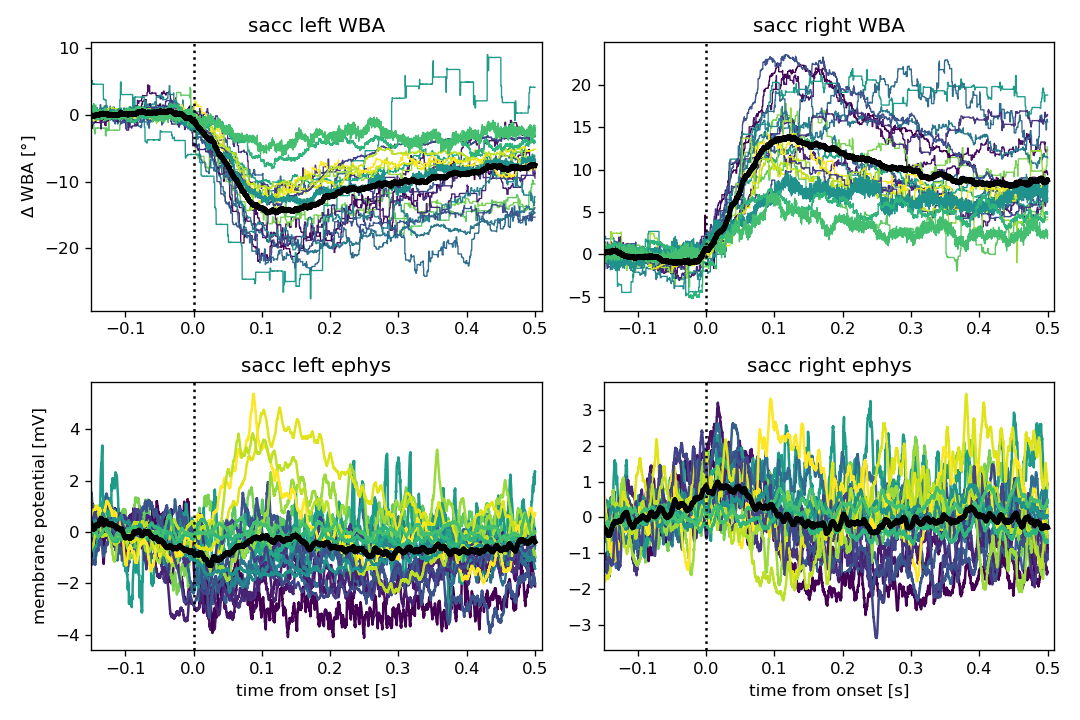

fly1_wtcs_20111222_cell1
fly1_wtcs_20120104_cell1
fly1_wtcs_20120104_cell2
fly1_wtcs_20120105_cell1
fly1_wtcs_20120105_cell2
fly1_wtcs_20120207_cell1
fly1_wtcs_20120217_cell1
fly1_wtcs_20120418_cell2
fly1_wtcs_20120501_cell1
fly1_wtcs_20120504_cell1
fly1_wtcs_20120508_cell1
fly1_wtcs_20120524_cell2
fly1_wtcs_20120605_cell1
fly1_wtcs_20130211_cell1
fly1_wtcs_20130424_cell1
fly1_wtcs_20130502_cell2
fly1_wtcs_20130506_cell1
fly1_wtcs_20130513_cell1
fly4_looming_20200420_cell1
fly3_looming_20200415_cell1
fly3_looming_20200417_cell1


In [14]:
f,ax=plt.subplots(2,2, figsize=(9,6))
plotlist = list(allSaccRightMeanEphys.keys())[:]
#plotcolors = plt.cm.BrBG(np.linspace(0,1,len(plotlist)))
# plotcolors = plt.cm.viridis((polAmp-min(polAmp))/(max(polAmp)-min(polAmp)))
plotcolors = plt.cm.viridis(np.linspace(0,1,len(plotlist)))[np.searchsorted(np.sort(polAmp), polAmp)]
i=-1
for k in plotlist:
    print(k)
    i+=1
#     if max(abs(allSaccLeftMeanWBA[k])) < 8:
#         print('left out', k)
#         continue
    ax[0,0].plot(np.arange(allSaccLeftMeanWBA[k].size)/10000.-0.15, allSaccLeftMeanWBA[k], color=plotcolors[i], linewidth=0.8)
    ax[0,1].plot(np.arange(allSaccRightMeanWBA[k].size)/10000.-0.15, allSaccRightMeanWBA[k], color=plotcolors[i], linewidth=0.8)
    ax[1,0].plot(np.arange(allSaccLeftMeanEphys[k].size)/10000.-0.15, allSaccLeftMeanEphys[k], color=plotcolors[i])
    ax[1,1].plot(np.arange(allSaccRightMeanEphys[k].size)/10000.-0.15, allSaccRightMeanEphys[k], color=plotcolors[i])
ax[0,0].set_title('sacc left WBA')
ax[0,1].set_title('sacc right WBA')
ax[1,0].set_title('sacc left ephys')
ax[1,1].set_title('sacc right ephys')
ax[0,0].set_ylabel('$\Delta$ WBA [°]')
ax[1,0].set_ylabel('membrane potential [mV]')
[a.axvline(0, linestyle=':', color='k') for a in ax.flatten()]
[a.set_xlim([-0.15,0.51]) for a in ax.flatten()]
ax[1,0].set_xlabel('time from onset [s]')
ax[1,1].set_xlabel('time from onset [s]')
# ax[0,0].legend(plotlist, framealpha=0.4)
plt.tight_layout()


In [15]:
# add a line for average

lw=3
padLen = max([v.size  for k,v in allSaccLeftMeanWBA.items()])
allTraces = np.array([np.pad(v,(0,padLen-v.size), 'constant', constant_values=np.nan) for _,v in allSaccLeftMeanWBA.items()])
ax[0,0].plot(np.arange(padLen)/10000.-0.15, np.nanmean(allTraces,axis=0), 'k-', linewidth=lw)

padLen = max([v.size  for k,v in allSaccRightMeanWBA.items()])
allTraces = np.array([np.pad(v,(0,padLen-v.size), 'constant', constant_values=np.nan) for _,v in allSaccRightMeanWBA.items()])
ax[0,1].plot(np.arange(padLen)/10000.-0.15, np.nanmean(allTraces,axis=0), 'k-', linewidth=lw)

padLen = max([v.size  for k,v in allSaccLeftMeanEphys.items()])
allTraces = np.array([np.pad(v,(0,padLen-v.size), 'constant', constant_values=np.nan) for _,v in allSaccLeftMeanEphys.items()])
ax[1,0].plot(np.arange(padLen)/10000.-0.15, np.nanmean(allTraces,axis=0), 'k-', linewidth=lw)

padLen = max([v.size  for k,v in allSaccRightMeanEphys.items()])
allTraces = np.array([np.pad(v,(0,padLen-v.size), 'constant', constant_values=np.nan) for _,v in allSaccRightMeanEphys.items()])
ax[1,1].plot(np.arange(padLen)/10000.-0.15, np.nanmean(allTraces,axis=0), 'k-', linewidth=lw)

In [16]:
# save
f.savefig(os.path.join(DATAPATH, 'spontaneousSaccades','oldData', 
                'cwtSorting_oldData_spontanSacc_perFly_withAvg.png'))
f.savefig(os.path.join(DATAPATH, 'spontaneousSaccades','oldData', 
                'cwtSorting_oldData_spontanSacc_perFly_withAvg.svg'))
# f.savefig(os.path.join(DATAPATH, 'spontaneousSaccades','oldData', 
#                 'cwtSorting_oldData_spontanSacc_perFly_withLegend_withAvg.png'))
# f.savefig(os.path.join(DATAPATH, 'spontaneousSaccades','oldData', 
#                 'cwtSorting_oldData_spontanSacc_perFly_withLegend_withAvg.svg'))

## plot subsets in different color families

In [18]:
subtype_dict = {'HSN': ('fly1_wtcs_20111222_cell1',
                        #'fly1_wtcs_20120203_cell1',#too low number of saccades
                        'fly1_wtcs_20120207_cell1',
                        'fly1_wtcs_20120504_cell1',
                        'fly1_wtcs_20120508_cell1',
                        'fly1_wtcs_20120418_cell2',
                        'fly1_wtcs_20130506_cell1',
                       ),
               'HSE': ('fly1_wtcs_20120104_cell1',
                       'fly1_wtcs_20120105_cell1',
                       'fly1_wtcs_20120501_cell1',
                       'fly1_wtcs_20120105_cell2',
                       'fly1_wtcs_20120524_cell2',
                       'fly1_wtcs_20130502_cell2',
                       'fly1_wtcs_20130513_cell1'),
               'HSS': ('fly1_wtcs_20120605_cell1',
                       'fly1_wtcs_20120104_cell2',
                       'fly1_wtcs_20130211_cell1',
                       'fly1_wtcs_20130424_cell1',
                       )
               }


### ephys

<IPython.core.display.Javascript object>


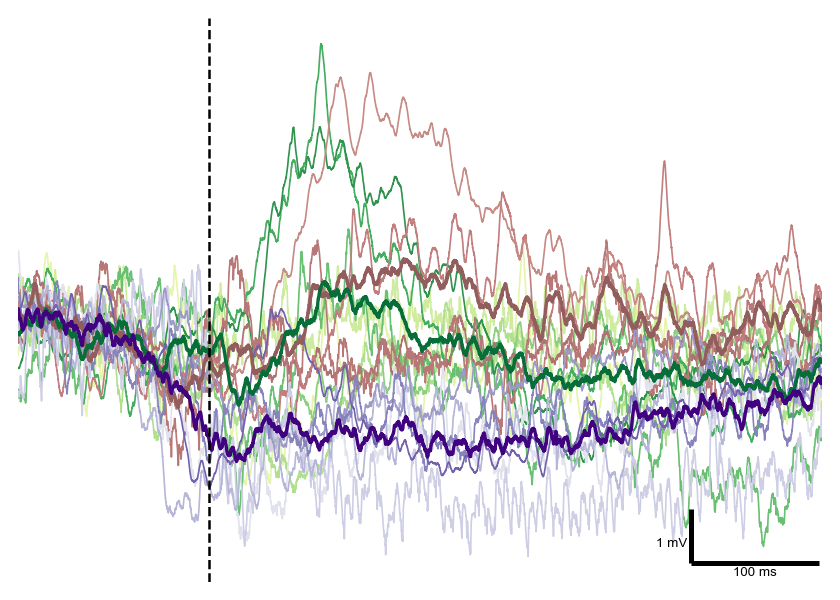

fly1_wtcs_20120104_cell1
fly1_wtcs_20120105_cell1
fly1_wtcs_20120501_cell1
fly1_wtcs_20120105_cell2
fly1_wtcs_20120524_cell2
fly1_wtcs_20130502_cell2
fly1_wtcs_20130513_cell1


In [20]:
f,ax=plt.subplots(1,1, figsize=(7,5))

plotlist = subtype_dict['HSE']

plotcolors = plt.cm.YlGn(np.linspace(0.2,0.7,len(plotlist)))
i=-1
for k in plotlist:
    print(k)
    data = allSaccLeftMeanEphys[k]
    i+=1
    ax.plot(np.arange(data.size)/10000.-0.15, data, color=plotcolors[i], linewidth=1., label=k)
# ax.legend()
# add average line
minLen = min([allSaccLeftMeanEphys[fid].size for fid in plotlist])
alldata = np.array([allSaccLeftMeanEphys[fid][:minLen] for fid in plotlist])
avg_HSE = np.mean(alldata, axis=0)
std_HSE = np.std(alldata, axis=0)/len(plotlist)
# ax.plot(np.arange(avg_HSE.size)/10000.-0.15,avg_HSE, color=plt.cm.YlGn(0.85), linewidth=2)

plt.tight_layout()

In [21]:
plotlist = subtype_dict['HSS']

plotcolors = plt.cm.pink(np.linspace(0.3,0.4,len(plotlist)))
i=-1
for k in plotlist:
    print(k)
    data = allSaccLeftMeanEphys[k]
    i+=1
    ax.plot(np.arange(data.size)/10000.-0.15, data, color=plotcolors[i], linewidth=1., label=k)
# ax.legend()
# add average line
minLen = min([allSaccLeftMeanEphys[fid].size for fid in plotlist])
alldata = np.array([allSaccLeftMeanEphys[fid][:minLen] for fid in plotlist])
avg_HSS = np.mean(alldata, axis=0)
std_HSS = np.std(alldata, axis=0)/len(plotlist)
# ax.plot(np.arange(avg_HSS.size)/10000.-0.15,avg_HSS, color=plt.cm.Purples(0.98), linewidth=2)

plt.tight_layout()

fly1_wtcs_20120605_cell1
fly1_wtcs_20120104_cell2
fly1_wtcs_20130211_cell1
fly1_wtcs_20130424_cell1


In [22]:
plotlist = subtype_dict['HSN']

plotcolors = plt.cm.Purples(np.linspace(0.2,0.7,len(plotlist)))
i=-1
for k in plotlist:
    print(k)
    data = allSaccLeftMeanEphys[k]
    i+=1
    ax.plot(np.arange(data.size)/10000.-0.15, data, color=plotcolors[i], linewidth=1., label=k)
# ax.legend()
# add average line
minLen = min([allSaccLeftMeanEphys[fid].size for fid in plotlist])
alldata = np.array([allSaccLeftMeanEphys[fid][:minLen] for fid in plotlist])
avg_HSN = np.mean(alldata, axis=0)
std_HSN = np.std(alldata, axis=0)/len(plotlist)
# ax.plot(np.arange(avg_HSN.size)/10000.-0.15,avg_HSN, color=plt.cm.Purples(0.98), linewidth=2)

plt.tight_layout()

fly1_wtcs_20111222_cell1
fly1_wtcs_20120207_cell1
fly1_wtcs_20120504_cell1
fly1_wtcs_20120508_cell1
fly1_wtcs_20120418_cell2
fly1_wtcs_20130506_cell1


In [23]:
ax.plot(np.arange(avg_HSS.size)/10000.-0.15,avg_HSS, color=plt.cm.pink(0.2), linewidth=2, label='mean HSS')
ax.plot(np.arange(avg_HSE.size)/10000.-0.15,avg_HSE, color=plt.cm.YlGn(0.85), linewidth=2, label='mean HSE')
ax.plot(np.arange(avg_HSN.size)/10000.-0.15,avg_HSN, color=plt.cm.Purples(0.99), linewidth=2, label='mean HSN')
# ax.legend()

In [24]:
ax.axvline(0, linestyle='--', color='k')
ax.set_xlim([-0.15,0.48])
# f.set_size_inches(85/25.4, 50/25.4)
add_scalebar(ax, matchx=False, sizex=0.1,  labelx='100 ms', matchy=False,
             sizey=1.0, labely='1 mV', barwidth=3)
plt.tight_layout()

In [25]:
# f.savefig(os.path.join(DATAPATH, 'spontaneousSaccades', 'oldData',
#                        'cwtSorted_oldData_spontSaccc_codedSubtype_perFly_AvgOnly_ephys.png'))
# f.savefig(os.path.join(DATAPATH, 'spontaneousSaccades', 'oldData',
#                        'cwtSorted_oldData_spontSaccc_codedSubtype_perFly_AvgOnly_ephys.svg'))

# f.savefig(os.path.join(DATAPATH, 'spontaneousSaccades', 'oldData',
#                        'cwtSorted_oldData_spontSaccc_codedSubtype_perFly_AvgOnly_incLegend_ephys.png'))
# f.savefig(os.path.join(DATAPATH, 'spontaneousSaccades', 'oldData',
#                        'cwtSorted_oldData_spontSaccc_codedSubtype_perFly_AvgOnly_incLegend_ephys.svg'))

<IPython.core.display.Javascript object>


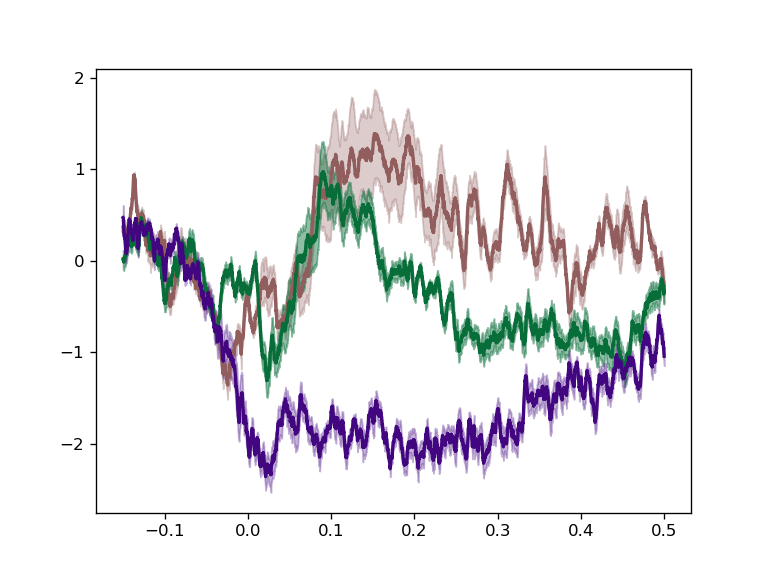

In [26]:
# plot of mean +- sd

f,ax=plt.subplots(1,1)

plotcolors = {'HSE':plt.cm.YlGn(0.85), 'HSN':plt.cm.Purples(0.98), 'HSS': plt.cm.pink(0.2)}
plotAlphas = [115/255, 77/255, 80/255]

ax.plot(np.arange(avg_HSS.size)/10000.-0.15, avg_HSS, color=plotcolors['HSS'], linewidth=2)
ax.fill_between(np.arange(avg_HSS.size)/10000.-0.15, avg_HSS+std_HSS, avg_HSS-std_HSS, 
                color=plotcolors['HSS'], alpha=plotAlphas[2])

ax.plot(np.arange(avg_HSE.size)/10000.-0.15, avg_HSE, color=plotcolors['HSE'], linewidth=2)
ax.fill_between(np.arange(avg_HSE.size)/10000.-0.15, avg_HSE+std_HSE, avg_HSE-std_HSE, 
                color=plotcolors['HSE'], alpha=plotAlphas[0])

ax.plot(np.arange(avg_HSN.size)/10000.-0.15, avg_HSN, color=plotcolors['HSN'], linewidth=2)
ax.fill_between(np.arange(avg_HSN.size)/10000.-0.15, avg_HSN+std_HSN, avg_HSN-std_HSN, 
                color=plotcolors['HSN'], alpha=plotAlphas[1])

### WBA

<IPython.core.display.Javascript object>


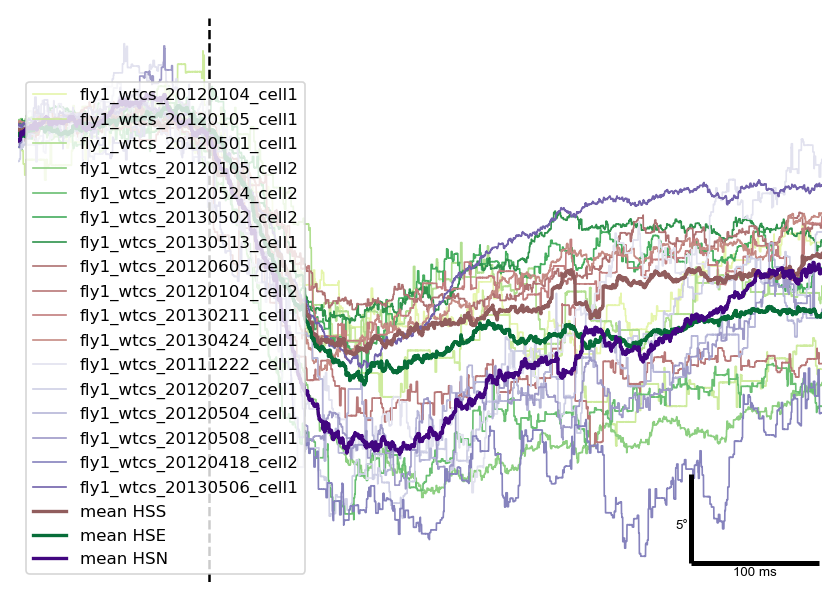

fly1_wtcs_20120104_cell1
fly1_wtcs_20120105_cell1
fly1_wtcs_20120501_cell1
fly1_wtcs_20120105_cell2
fly1_wtcs_20120524_cell2
fly1_wtcs_20130502_cell2
fly1_wtcs_20130513_cell1


In [34]:
f,ax=plt.subplots(1,1, figsize=(7,5))

plotlist = subtype_dict['HSE']

plotcolors = plt.cm.YlGn(np.linspace(0.2,0.7,len(plotlist)))
i=-1
for k in plotlist:
    print(k)
    data = allSaccLeftMeanWBA[k]
    i+=1
    ax.plot(np.arange(data.size)/10000.-0.15, data, color=plotcolors[i], linewidth=1., label=k)
# ax.legend()
# add average line
minLen = min([allSaccLeftMeanWBA[fid].size for fid in plotlist])
alldata = np.array([allSaccLeftMeanWBA[fid][:minLen] for fid in plotlist])
avg_HSE = np.mean(alldata, axis=0)
std_HSE = np.std(alldata, axis=0)/len(plotlist)
# ax.plot(np.arange(avg_HSE.size)/10000.-0.15,avg_HSE, color=plt.cm.YlGn(0.85), linewidth=2)

plt.tight_layout()

In [35]:
plotlist = subtype_dict['HSS']

plotcolors = plt.cm.pink(np.linspace(0.3,0.4,len(plotlist)))
i=-1
for k in plotlist:
    print(k)
    data = allSaccLeftMeanWBA[k]
    i+=1
    ax.plot(np.arange(data.size)/10000.-0.15, data, color=plotcolors[i], linewidth=1., label=k)
# ax.legend()
# add average line
minLen = min([allSaccLeftMeanWBA[fid].size for fid in plotlist])
alldata = np.array([allSaccLeftMeanWBA[fid][:minLen] for fid in plotlist])
avg_HSS = np.mean(alldata, axis=0)
std_HSS = np.std(alldata, axis=0)/len(plotlist)
# ax.plot(np.arange(avg_HSS.size)/10000.-0.15,avg_HSS, color=plt.cm.Purples(0.98), linewidth=2)

plt.tight_layout()

fly1_wtcs_20120605_cell1
fly1_wtcs_20120104_cell2
fly1_wtcs_20130211_cell1
fly1_wtcs_20130424_cell1


In [36]:
plotlist = subtype_dict['HSN']

plotcolors = plt.cm.Purples(np.linspace(0.2,0.7,len(plotlist)))
i=-1
for k in plotlist:
    print(k)
    data = allSaccLeftMeanWBA[k]
    i+=1
    ax.plot(np.arange(data.size)/10000.-0.15, data, color=plotcolors[i], linewidth=1., label=k)
# ax.legend()
# add average line
minLen = min([allSaccLeftMeanWBA[fid].size for fid in plotlist])
alldata = np.array([allSaccLeftMeanWBA[fid][:minLen] for fid in plotlist])
avg_HSN = np.mean(alldata, axis=0)
std_HSN = np.std(alldata, axis=0)/len(plotlist)
# ax.plot(np.arange(avg_HSN.size)/10000.-0.15,avg_HSN, color=plt.cm.Purples(0.98), linewidth=2)

plt.tight_layout()

fly1_wtcs_20111222_cell1
fly1_wtcs_20120207_cell1
fly1_wtcs_20120504_cell1
fly1_wtcs_20120508_cell1
fly1_wtcs_20120418_cell2
fly1_wtcs_20130506_cell1


In [37]:
ax.plot(np.arange(avg_HSS.size)/10000.-0.15,avg_HSS, color=plt.cm.pink(0.2), linewidth=2, label='mean HSS')
ax.plot(np.arange(avg_HSE.size)/10000.-0.15,avg_HSE, color=plt.cm.YlGn(0.85), linewidth=2, label='mean HSE')
ax.plot(np.arange(avg_HSN.size)/10000.-0.15,avg_HSN, color=plt.cm.Purples(0.98), linewidth=2, label='mean HSN')
# ax.legend()

In [38]:
ax.axvline(0, linestyle='--', color='k')
ax.set_xlim([-0.15,0.48])
# f.set_size_inches(85/25.4, 50/25.4)
add_scalebar(ax, matchx=False, sizex=0.1,  labelx='100 ms', matchy=False,
             sizey=5.0, labely='5°', barwidth=3)
#             sizey=10.0, labely='10°', barwidth=3)
plt.tight_layout()

In [40]:
ax.legend()
# ax.get_legend().remove()

In [41]:
# f.savefig(os.path.join(DATAPATH, 'spontaneousSaccades', 'oldData',
#                        'cwtSorted_oldData_spontSaccc_codedSubtype_perFly_AvgOnly_wingDiff.png'))
# f.savefig(os.path.join(DATAPATH, 'spontaneousSaccades', 'oldData',
#                        'cwtSorted_oldData_spontSaccc_codedSubtype_perFly_AvgOnly_wingDiff.svg'))

# f.savefig(os.path.join(DATAPATH, 'spontaneousSaccades', 'oldData',
#                        'cwtSorted_oldData_spontSaccc_codedSubtype_perFly_AvgOnly_incLegend_wingDiff.png'))
# f.savefig(os.path.join(DATAPATH, 'spontaneousSaccades', 'oldData',
#                        'cwtSorted_oldData_spontSaccc_codedSubtype_perFly_AvgOnly_incLegend_wingDiff.svg'))

## plot amplitude of behavior vs ephys

In [42]:
# this is modified form above, redo to put in dict structure
# refer to previosu cell to avoid mistakes
polAmp_dict={}
saccAmp_dict={}

plotlist = list(allSaccRightMeanEphys.keys())[:]

for flyid in plotlist[:]:
    #f,ax = plt.subplots(1,2)
    
    d=allSaccLeftMeanEphys[flyid]
    #ax[0].plot(d)
    d = ndimage.gaussian_filter1d(d, 60)
    #ax[0].plot(d)
    ix = int(np.argmax(signal.medfilt(np.abs(d[int(0.15*10000):int(0.35*10000)]), 101))+0.15*10000)
    #ax[0].plot(ix, d[ix], 'ro')
    polAmp_dict[flyid] = d[ix]

    d=allSaccLeftMeanWBA[flyid]
    #ax[1].plot(d)
    #d = signal.medfilt(d, 201)
    d = ndimage.gaussian_filter1d(d, 60)
    #ax[1].plot(d)
    ix = int(np.argmax(signal.medfilt(np.abs(d[int(0.15*10000):int(0.35*10000)]), 101))+0.15*10000)
    #ax[1].plot(ix, d[ix], 'ro')
    saccAmp_dict[flyid] = d[ix]


In [43]:
# simpler versionf or first look
import plotly.express as px
px.scatter(x=saccAmp_dict, y=polAmp_dict, text=list(saccAmp_dict.keys()))

<IPython.core.display.Javascript object>


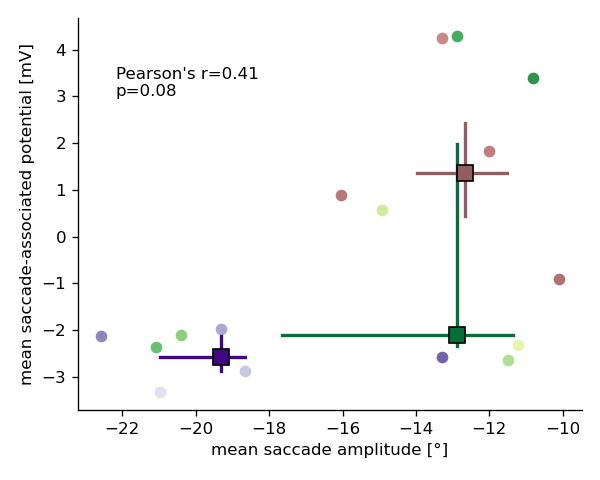

HSE
fly1_wtcs_20120104_cell1
fly1_wtcs_20120105_cell1
fly1_wtcs_20120501_cell1
fly1_wtcs_20120105_cell2
fly1_wtcs_20120524_cell2
fly1_wtcs_20130502_cell2
fly1_wtcs_20130513_cell1
HSS
fly1_wtcs_20120605_cell1
fly1_wtcs_20120104_cell2
fly1_wtcs_20130211_cell1
fly1_wtcs_20130424_cell1
HSN
fly1_wtcs_20120207_cell1
fly1_wtcs_20120504_cell1
fly1_wtcs_20120508_cell1
fly1_wtcs_20120418_cell2
fly1_wtcs_20130506_cell1


In [52]:
f,ax=plt.subplots(1,1, figsize=(5,4))

#HSE
# plotlist = subtype_dict['HSE']
# remove the problematic one(s)
plotlist = [flyid for flyid in subtype_dict['HSE'] if not flyid in behavioral_outliers]
plotcolors = plt.cm.YlGn(np.linspace(0.2,0.7,len(plotlist)))
i=0
print('HSE')
for i,flyid in enumerate(plotlist):
    if flyid in behavioral_outliers:
        continue
    print(flyid)
    #ax.plot(np.arange(data.size)/10000.-0.15, data, color=plotcolors[i], linewidth=1.)
    ax.scatter(saccAmp_dict[flyid], polAmp_dict[flyid], color=plotcolors[i], marker='o')
    i+=1
# calculate average dot
# avg_HSE_wba = np.mean( [saccAmp_dict[flyid] for flyid in plotlist])
# avg_HSE_ephys = np.mean( [polAmp_dict[flyid] for flyid in plotlist])
# std_HSE_wba = np.std( [saccAmp_dict[flyid] for flyid in plotlist])
# std_HSE_ephys = np.std( [polAmp_dict[flyid] for flyid in plotlist])
# median and quartile
avg_HSE_wba = np.median( [saccAmp_dict[flyid] for flyid in plotlist])
avg_HSE_ephys = np.median( [polAmp_dict[flyid] for flyid in plotlist])
quant_HSE_wba = np.quantile( [saccAmp_dict[flyid] for flyid in plotlist], [0.25,0.75])
quant_HSE_ephys = np.quantile( [polAmp_dict[flyid] for flyid in plotlist], [0.25,0.75])

# HSS
# plotlist = subtype_dict['HSS']
plotlist = [flyid for flyid in subtype_dict['HSS'] if not flyid in behavioral_outliers]
plotcolors = plt.cm.pink(np.linspace(0.3,0.4,len(plotlist)))
i=0
print('HSS')
for i,flyid in enumerate(plotlist):
    if flyid in behavioral_outliers:
        continue
    print(flyid)
    #ax.plot(np.arange(data.size)/10000.-0.15, data, color=plotcolors[i], linewidth=1.)
    ax.plot(saccAmp_dict[flyid], polAmp_dict[flyid], color=plotcolors[i], marker='o')
    i+=1
# avg_HSS_wba = np.mean( [saccAmp_dict[flyid] for flyid in plotlist])
# avg_HSS_ephys = np.mean( [polAmp_dict[flyid] for flyid in plotlist])
# std_HSS_wba = np.std( [saccAmp_dict[flyid] for flyid in plotlist])
# std_HSS_ephys = np.std( [polAmp_dict[flyid] for flyid in plotlist])
# median and quartile
avg_HSS_wba = np.median( [saccAmp_dict[flyid] for flyid in plotlist])
avg_HSS_ephys = np.median( [polAmp_dict[flyid] for flyid in plotlist])
quant_HSS_wba = np.quantile( [saccAmp_dict[flyid] for flyid in plotlist], [0.25,0.75])
quant_HSS_ephys = np.quantile( [polAmp_dict[flyid] for flyid in plotlist], [0.25,0.75])

# HSN
# plotlist = subtype_dict['HSN']
plotlist = [flyid for flyid in subtype_dict['HSN'] if not flyid in behavioral_outliers]
plotcolors = plt.cm.Purples(np.linspace(0.2,0.7,len(plotlist)))
i=0
print('HSN')
for i,flyid in enumerate(plotlist):
    if flyid in behavioral_outliers:
        continue
    print(flyid)
    #ax.plot(np.arange(data.size)/10000.-0.15, data, color=plotcolors[i], linewidth=1.)
    ax.plot(saccAmp_dict[flyid], polAmp_dict[flyid], color=plotcolors[i], marker='o')
    i+=1
# avg_HSN_wba = np.mean( [saccAmp_dict[flyid] for flyid in plotlist])
# avg_HSN_ephys = np.mean( [polAmp_dict[flyid] for flyid in plotlist])
# std_HSN_wba = np.std( [saccAmp_dict[flyid] for flyid in plotlist])
# std_HSN_ephys = np.std( [polAmp_dict[flyid] for flyid in plotlist])
# # median and quartile
avg_HSN_wba = np.median( [saccAmp_dict[flyid] for flyid in plotlist])
avg_HSN_ephys = np.median( [polAmp_dict[flyid] for flyid in plotlist])
quant_HSN_wba = np.quantile( [saccAmp_dict[flyid] for flyid in plotlist], [0.25,0.75])
quant_HSN_ephys = np.quantile( [polAmp_dict[flyid] for flyid in plotlist], [0.25,0.75])


ax.set_xlabel('mean saccade amplitude [°]')
ax.set_ylabel('mean saccade-associated potential [mV]')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

In [54]:
# add average dots
ax.plot(avg_HSE_wba, avg_HSE_ephys, color=plt.cm.YlGn(0.85),
        marker='s',markersize=10,markeredgecolor='k',linewidth=2)
ax.plot(avg_HSS_wba, avg_HSS_ephys, color=plt.cm.pink(0.2),
        marker='s',markersize=10,markeredgecolor='k',linewidth=2)
ax.plot(avg_HSN_wba, avg_HSN_ephys, color=plt.cm.Purples(0.98),
        marker='s',markersize=10,markeredgecolor='k',linewidth=2)

In [46]:
# plotting mean +- sd
ax.errorbar(avg_HSE_wba, avg_HSE_ephys, xerr=std_HSE_wba, yerr=std_HSE_ephys, color=plt.cm.YlGn(0.85),
        marker='s',markersize=10,markeredgecolor='k',linewidth=2)
ax.errorbar(avg_HSS_wba, avg_HSS_ephys, xerr=std_HSS_wba, yerr=std_HSS_ephys, color=plt.cm.pink(0.2),
        marker='s',markersize=10,markeredgecolor='k',linewidth=2)
ax.errorbar(avg_HSN_wba, avg_HSN_ephys, xerr=std_HSN_wba, yerr=std_HSN_ephys, color=plt.cm.Purples(0.98),
        marker='s',markersize=10,markeredgecolor='k',linewidth=2)

<ErrorbarContainer object of 3 artists>

In [53]:
# plot whiskers for percentiles

ax.plot(quant_HSE_wba,[avg_HSE_ephys,avg_HSE_ephys], color=plt.cm.YlGn(0.85), marker=None,linewidth=2)
ax.plot([avg_HSE_wba,avg_HSE_wba], quant_HSE_ephys, color=plt.cm.YlGn(0.85), marker=None,linewidth=2)

ax.plot(quant_HSS_wba,[avg_HSS_ephys,avg_HSS_ephys], color=plt.cm.pink(0.2), marker=None,linewidth=2)
ax.plot([avg_HSS_wba,avg_HSS_wba], quant_HSS_ephys, color=plt.cm.pink(0.2), marker=None,linewidth=2)

ax.plot(quant_HSN_wba,[avg_HSN_ephys,avg_HSN_ephys], color=plt.cm.Purples(0.98), marker=None,linewidth=2)
ax.plot([avg_HSN_wba,avg_HSN_wba], quant_HSN_ephys, color=plt.cm.Purples(0.98), marker=None,linewidth=2)

## correlation wba <-> ephys

In [56]:
saccAmp = [v for k,v in saccAmp_dict.items() if not k in behavioral_outliers]
polAmp = [v for k,v in polAmp_dict.items() if not k in behavioral_outliers]

print(f'Pearson R: {stats.pearsonr(saccAmp, polAmp)}')
print(f'Spearman rho: {stats.spearmanr(saccAmp, polAmp)}')
stats.linregress(saccAmp, polAmp)

Pearson R: (0.40882808644691815, 0.08222007797856731)
Spearman rho: SpearmanrResult(correlation=0.3614035087719299, pvalue=0.12843517785910147)


LinregressResult(slope=0.20366431485595093, intercept=2.5649462980359363, rvalue=0.4088280864469182, pvalue=0.08222007797856716, stderr=0.11026448480091604, intercept_stderr=1.7867253338312972)

In [57]:
r,p = stats.pearsonr(saccAmp, polAmp)
ax.text(0.075, 0.8, f"Pearson's r={r:.2f}\np={p:.2f}", transform=ax.transAxes)

Text(0.075, 0.8, "Pearson's r=0.41\np=0.08")